In [1]:
import gdal
from osgeo import gdal
from numpy import *

import matplotlib.pyplot as plt
%matplotlib inline

import rasterio
from rasterio import plot

from spectral import *
import spectral.io.envi

from rasterio.plot import show

In [2]:
from osgeo import gdal, gdalnumeric, ogr
from PIL import Image, ImageDraw
import os
import numpy as np

def clip_raster(rast, features_path, gt=None, nodata=-9999):
    '''
    Clips a raster (given as either a gdal.Dataset or as a numpy.array
    instance) to a polygon layer provided by a Shapefile (or other vector
    layer). If a numpy.array is given, a "GeoTransform" must be provided
    (via dataset.GetGeoTransform() in GDAL). Returns an array. Clip features
    must be a dissolved, single-part geometry (not multi-part). Modified from:

    http://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html
    #clip-a-geotiff-with-shapefile

    Arguments:
        rast            A gdal.Dataset or a NumPy array
        features_path   The path to the clipping features
        gt              An optional GDAL GeoTransform to use instead
        nodata          The NoData value; defaults to -9999.
    '''
    def array_to_image(a):
        '''
        Converts a gdalnumeric array to a Python Imaging Library (PIL) Image.
        '''
        i = Image.fromstring('L',(a.shape[1], a.shape[0]),
            (a.astype('b')).tostring())
        return i

    def image_to_array(i):
        '''
        Converts a Python Imaging Library (PIL) array to a gdalnumeric image.
        '''
        a = gdalnumeric.fromstring(i.tobytes(), 'b')
        a.shape = i.im.size[1], i.im.size[0]
        return a

    def world_to_pixel(geo_matrix, x, y):
        '''
        Uses a gdal geomatrix (gdal.GetGeoTransform()) to calculate
        the pixel location of a geospatial coordinate; from:
        http://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html#clip-a-geotiff-with-shapefile
        '''
        ulX = geo_matrix[0]
        ulY = geo_matrix[3]
        xDist = geo_matrix[1]
        yDist = geo_matrix[5]
        rtnX = geo_matrix[2]
        rtnY = geo_matrix[4]
        pixel = int((x - ulX) / xDist)
        line = int((ulY - y) / xDist)
        return (pixel, line)

    # Can accept either a gdal.Dataset or numpy.array instance
    if not isinstance(rast, np.ndarray):
        gt = rast.GetGeoTransform()
        rast = rast.ReadAsArray()

    # Create an OGR layer from a boundary shapefile
    features = ogr.Open(features_path)
    if features.GetDriver().GetName() == 'ESRI Shapefile':
        lyr = features.GetLayer(os.path.split(os.path.splitext(features_path)[0])[1])

    else:
        lyr = features.GetLayer()

    # Get the first feature
    poly = lyr.GetNextFeature()

    # Convert the layer extent to image pixel coordinates
    minX, maxX, minY, maxY = lyr.GetExtent()
    ulX, ulY = world_to_pixel(gt, minX, maxY)
    lrX, lrY = world_to_pixel(gt, maxX, minY)

    # Calculate the pixel size of the new image
    pxWidth = int(lrX - ulX)
    pxHeight = int(lrY - ulY)

    # If the clipping features extend out-of-bounds and ABOVE the raster...
    if gt[3] < maxY:
        # In such a case... ulY ends up being negative--can't have that!
        iY = ulY
        ulY = 0

    # Multi-band image?
    try:
        clip = rast[:, ulY:lrY, ulX:lrX]

    except IndexError:
        clip = rast[ulY:lrY, ulX:lrX]

    # Create a new geomatrix for the image
    gt2 = list(gt)
    gt2[0] = minX
    gt2[3] = maxY

    # Map points to pixels for drawing the boundary on a blank 8-bit,
    #   black and white, mask image.
    points = []
    pixels = []
    geom = poly.GetGeometryRef()
    pts = geom.GetGeometryRef(0)

    for p in range(pts.GetPointCount()):
        points.append((pts.GetX(p), pts.GetY(p)))

    for p in points:
        pixels.append(world_to_pixel(gt2, p[0], p[1]))

    raster_poly = Image.new('L', (pxWidth, pxHeight), 1)
    rasterize = ImageDraw.Draw(raster_poly)
    rasterize.polygon(pixels, 0) # Fill with zeroes

    # If the clipping features extend out-of-bounds and ABOVE the raster...
    if gt[3] < maxY:
        # The clip features were "pushed down" to match the bounds of the
        #   raster; this step "pulls" them back up
        premask = image_to_array(raster_poly)
        # We slice out the piece of our clip features that are "off the map"
        mask = np.ndarray((premask.shape[-2] - abs(iY), premask.shape[-1]), premask.dtype)
        mask[:] = premask[abs(iY):, :]
        mask.resize(premask.shape) # Then fill in from the bottom

        # Most importantly, push the clipped piece down
        gt2[3] = maxY - (maxY - gt[3])

    else:
        mask = image_to_array(raster_poly)

    # Clip the image using the mask
    try:
        clip = gdalnumeric.choose(mask, (clip, nodata))

    # If the clipping features extend out-of-bounds and BELOW the raster...
    except ValueError:
        # We have to cut the clipping features to the raster!
        rshp = list(mask.shape)
        if mask.shape[-2] != clip.shape[-2]:
            rshp[0] = clip.shape[-2]

        if mask.shape[-1] != clip.shape[-1]:
            rshp[1] = clip.shape[-1]

        mask.resize(*rshp, refcheck=False)

        clip = gdalnumeric.choose(mask, (clip, nodata))

    return (clip, ulX, ulY, gt2)

In [18]:
dlist = ['VNP46A1.A2020018.h29v05.001.2020053132316.h5',
  'VNP46A1.A2020019.h29v05.001.2020053152645.h5',
  'VNP46A1.A2020020.h29v05.001.2020053184244.h5',
  'VNP46A1.A2020021.h29v05.001.2020053202244.h5',
  'VNP46A1.A2020022.h29v05.001.2020053225819.h5',
  'VNP46A1.A2020024.h29v05.001.2020054012713.h5',
  'VNP46A1.A2020025.h29v05.001.2020054022004.h5',
  'VNP46A1.A2020027.h29v05.001.2020054062105.h5',
  'VNP46A1.A2020028.h29v05.001.2020054073349.h5',
  'VNP46A1.A2020029.h29v05.001.2020054103630.h5',
 'VNP46A1.A2020030.h29v05.001.2020054110114.h5',
  'VNP46A1.A2020031.h29v05.001.2020054114110.h5',
  'VNP46A1.A2020032.h29v05.001.2020054124214.h5',
  'VNP46A1.A2020033.h29v05.001.2020054093443.h5',
  'VNP46A1.A2020034.h29v05.001.2020054112446.h5',
  'VNP46A1.A2020035.h29v05.001.2020054120539.h5',
  'VNP46A1.A2020036.h29v05.001.2020054135046.h5']

2020-01-18


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:35: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


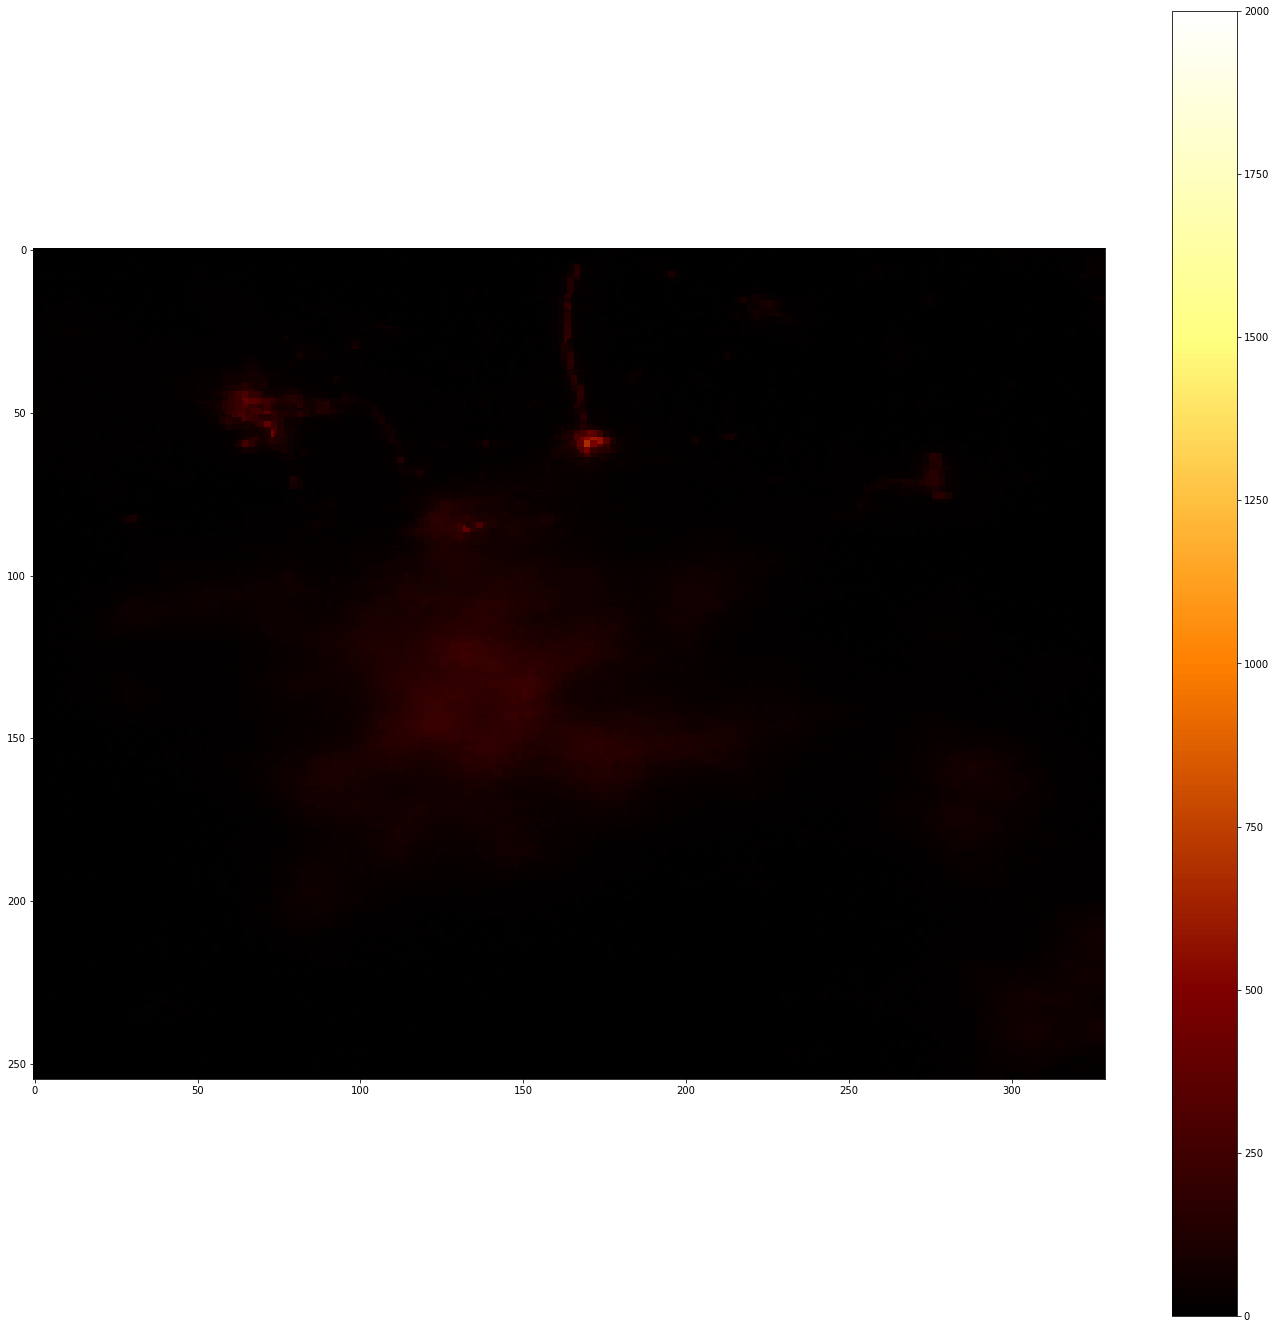

2020-01-19


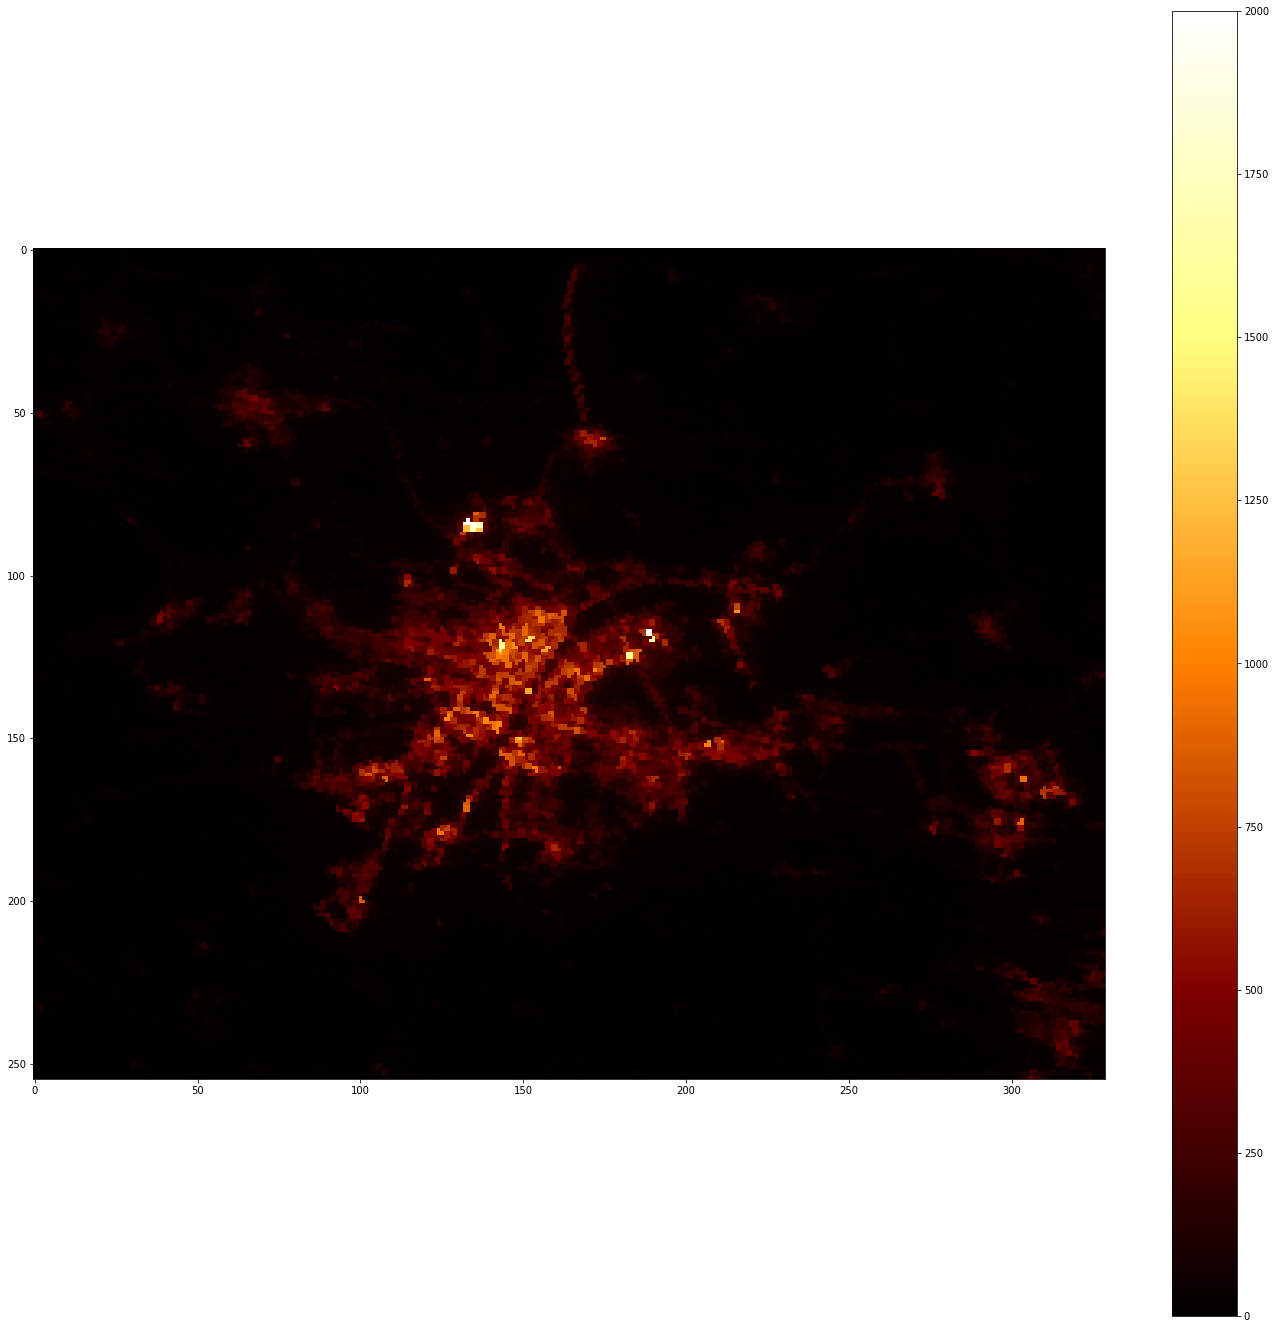

2020-01-20


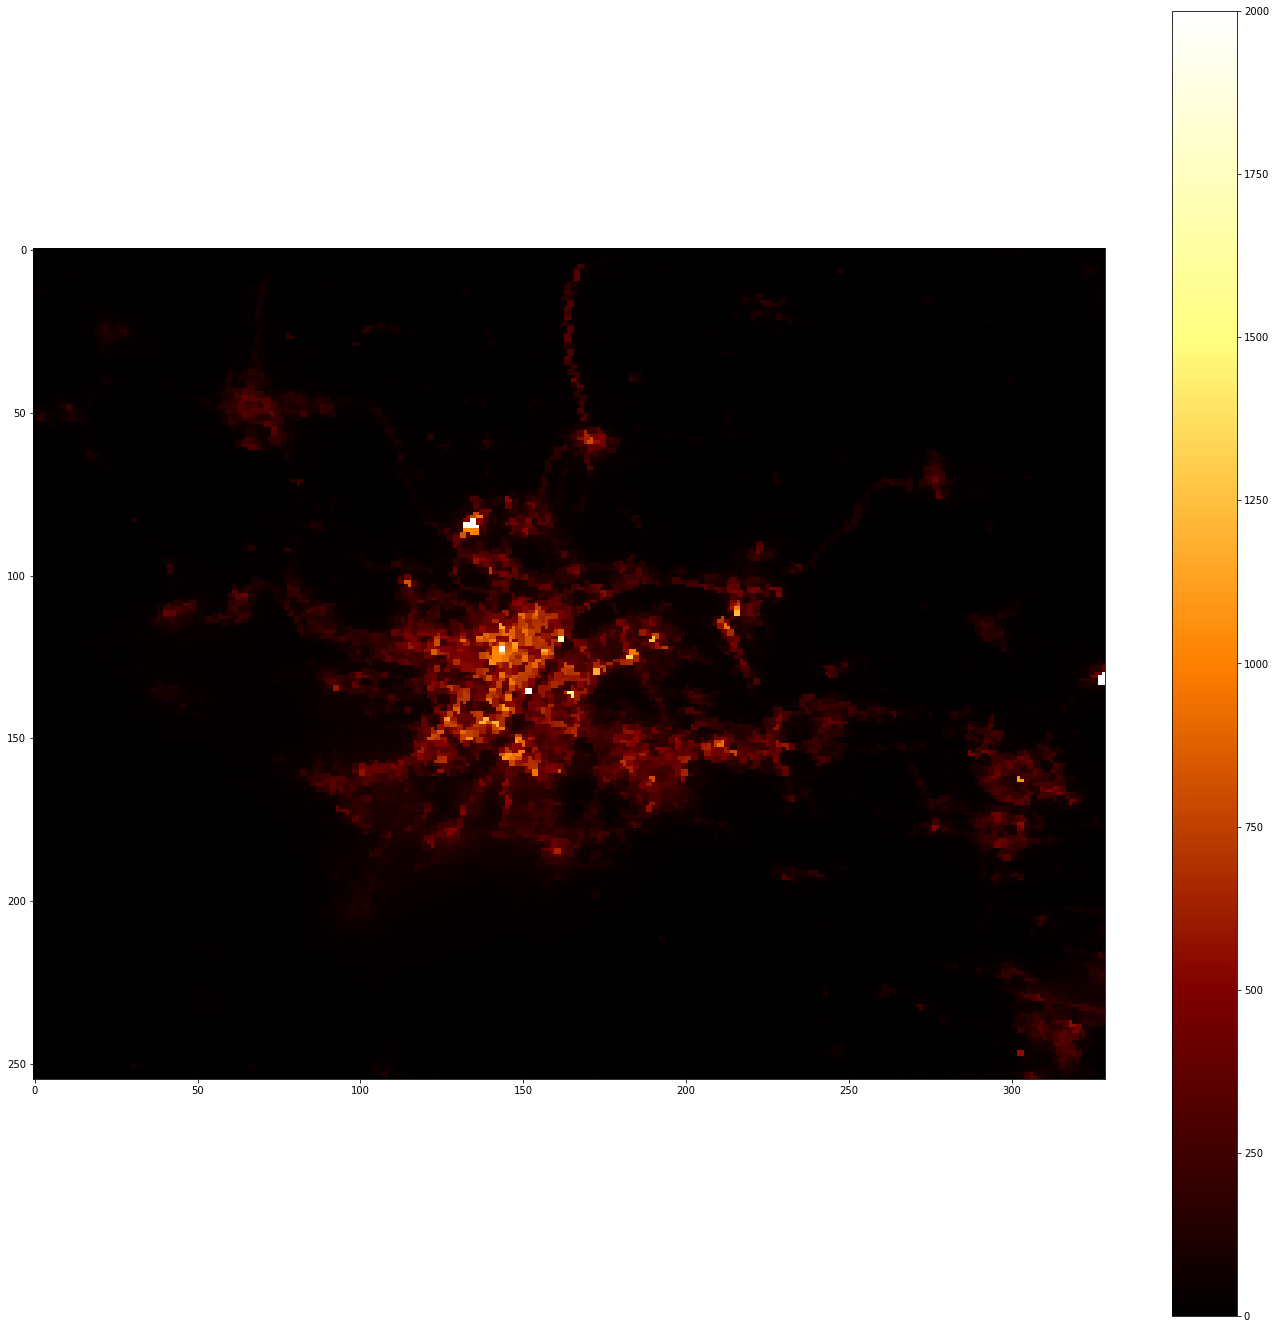

2020-01-21


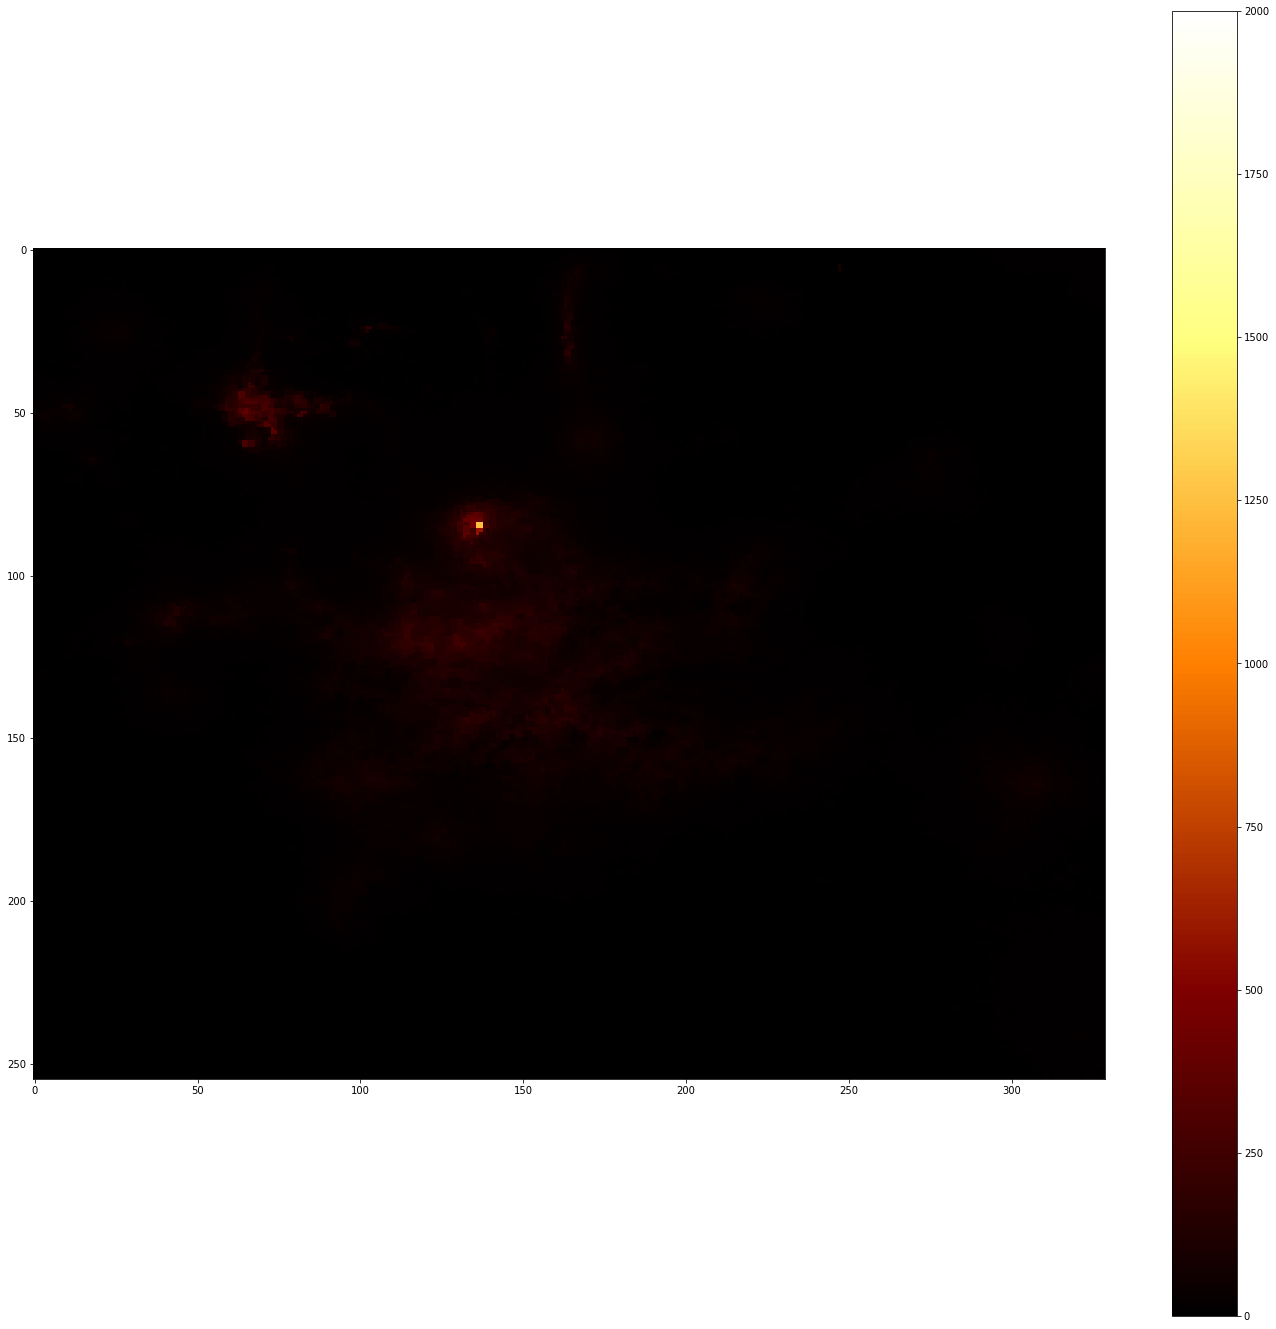

2020-01-22


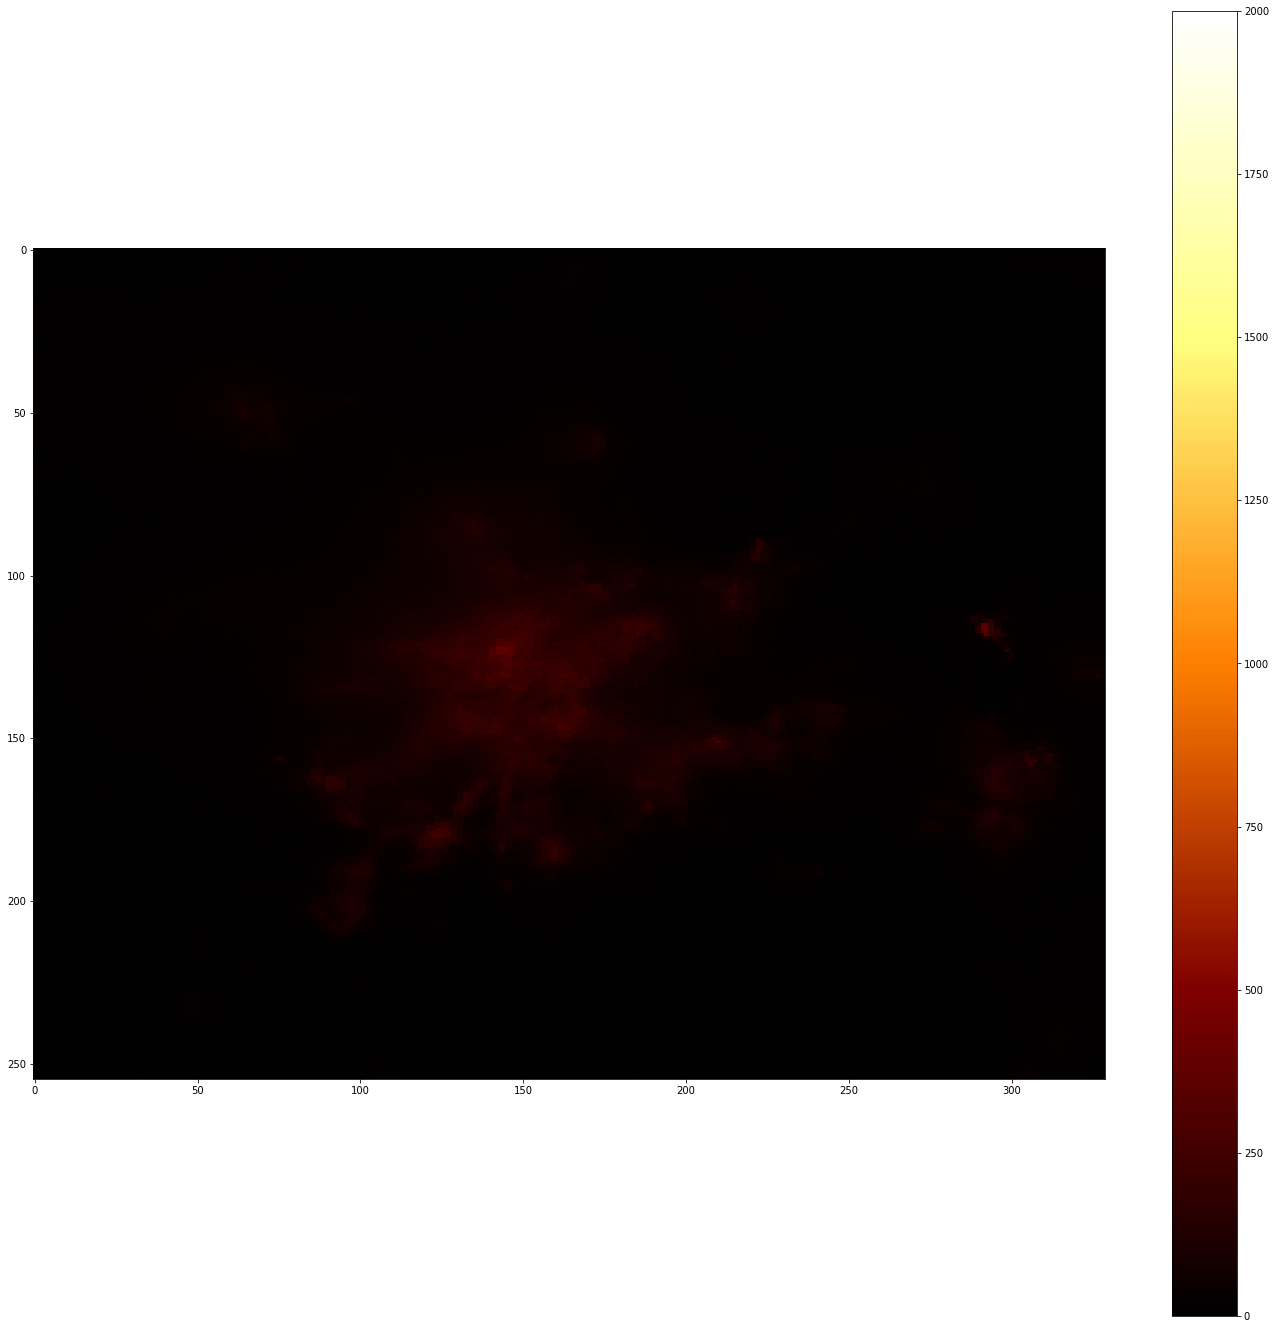

2020-01-24


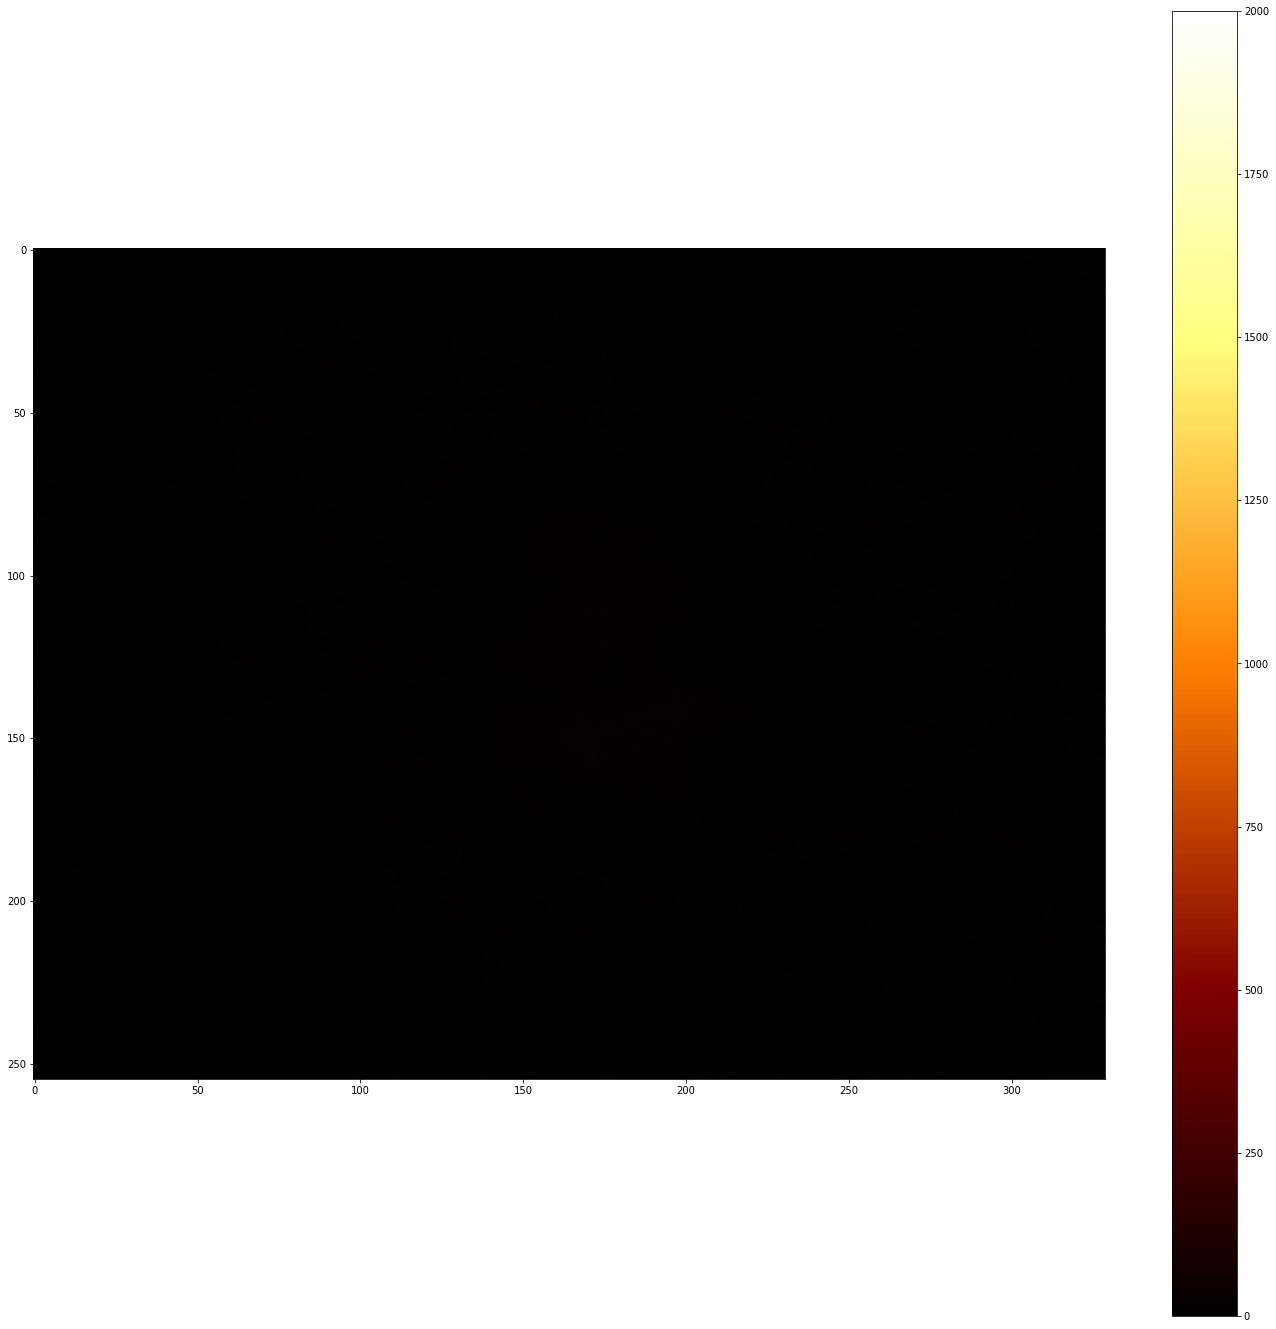

2020-01-25


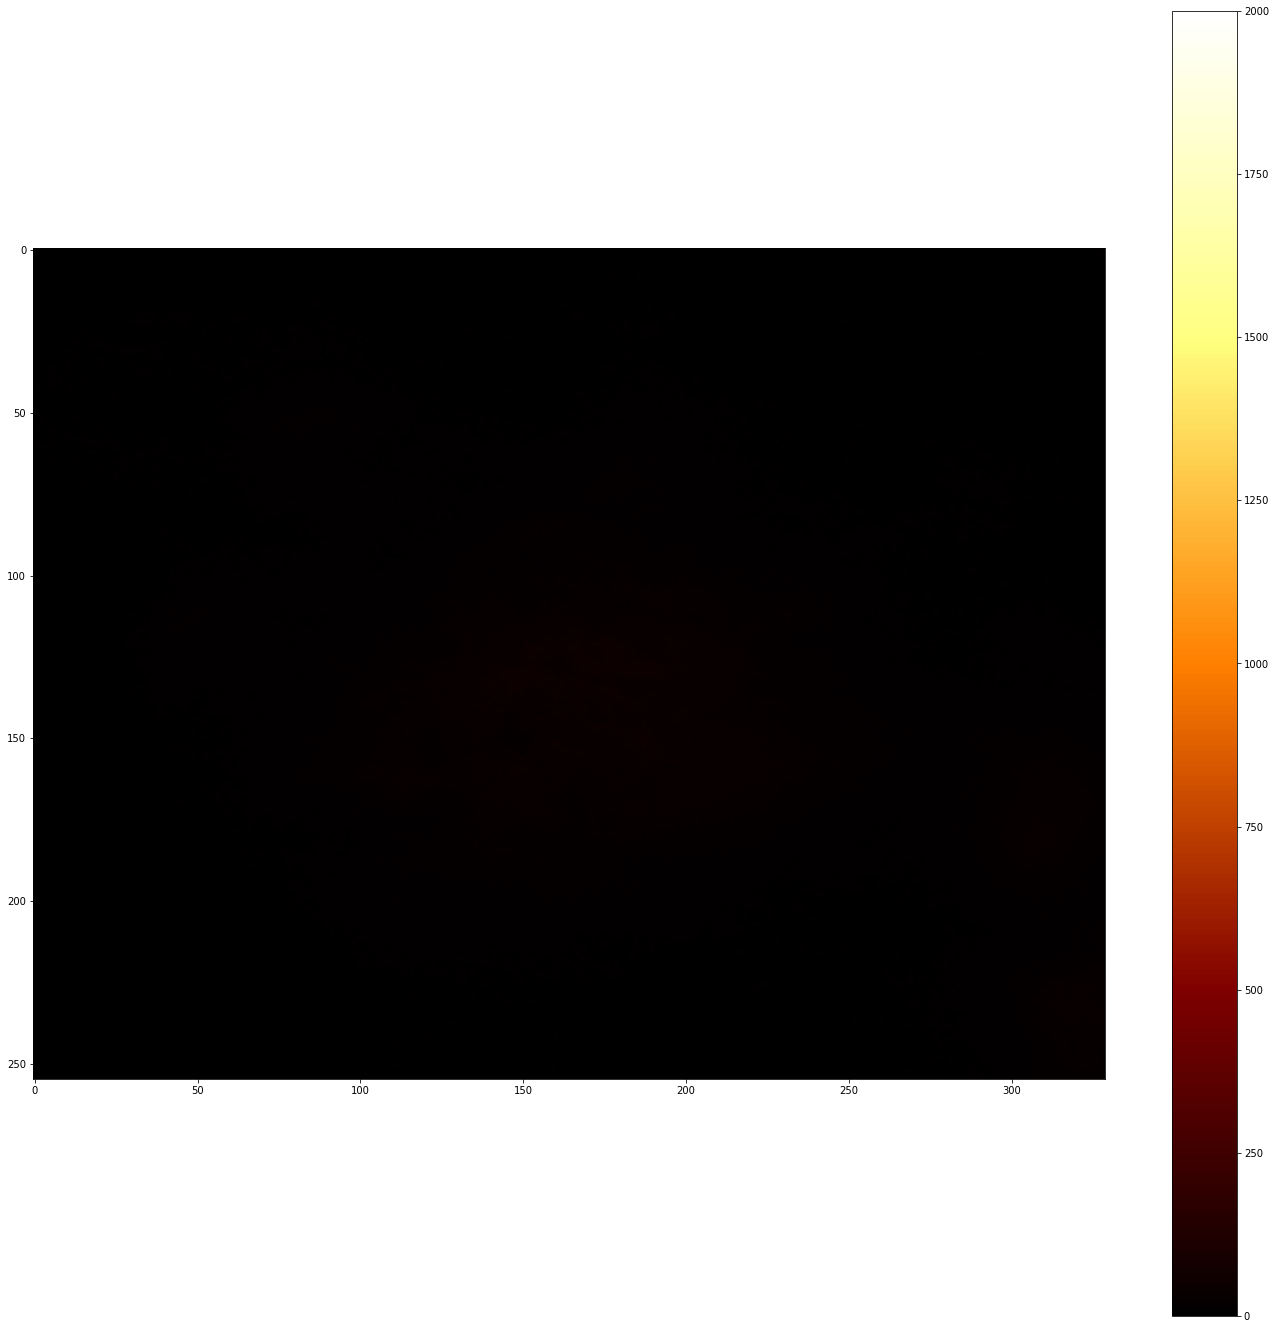

2020-01-27


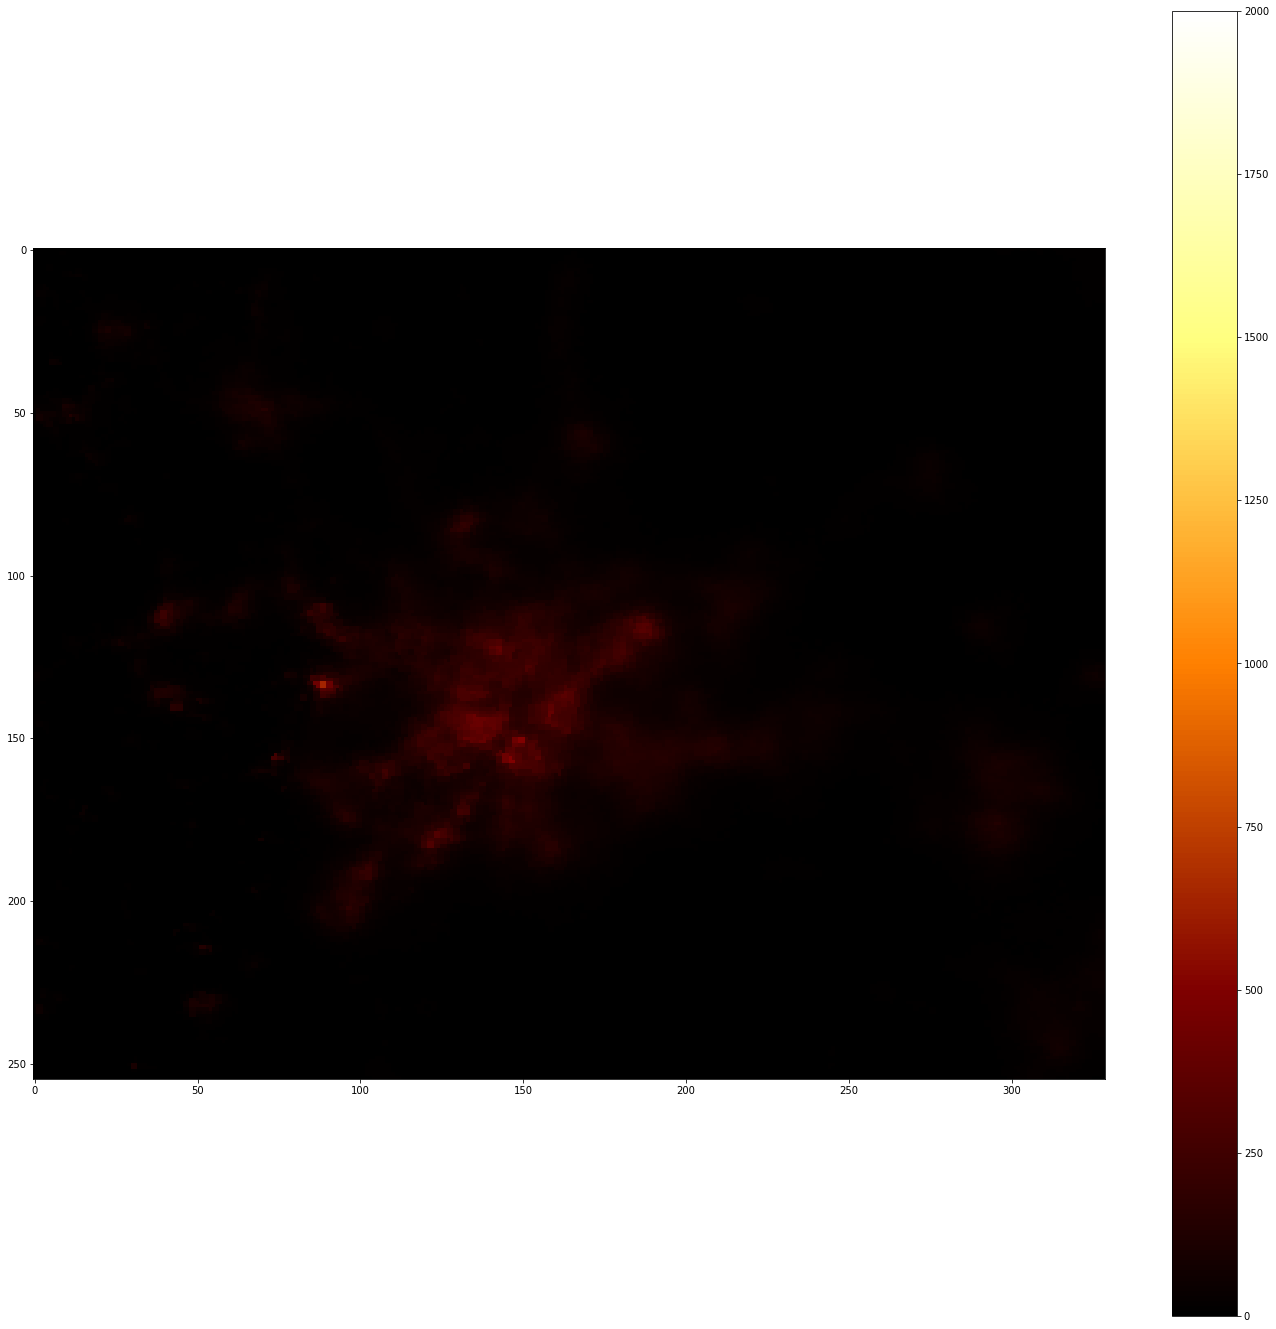

2020-01-28


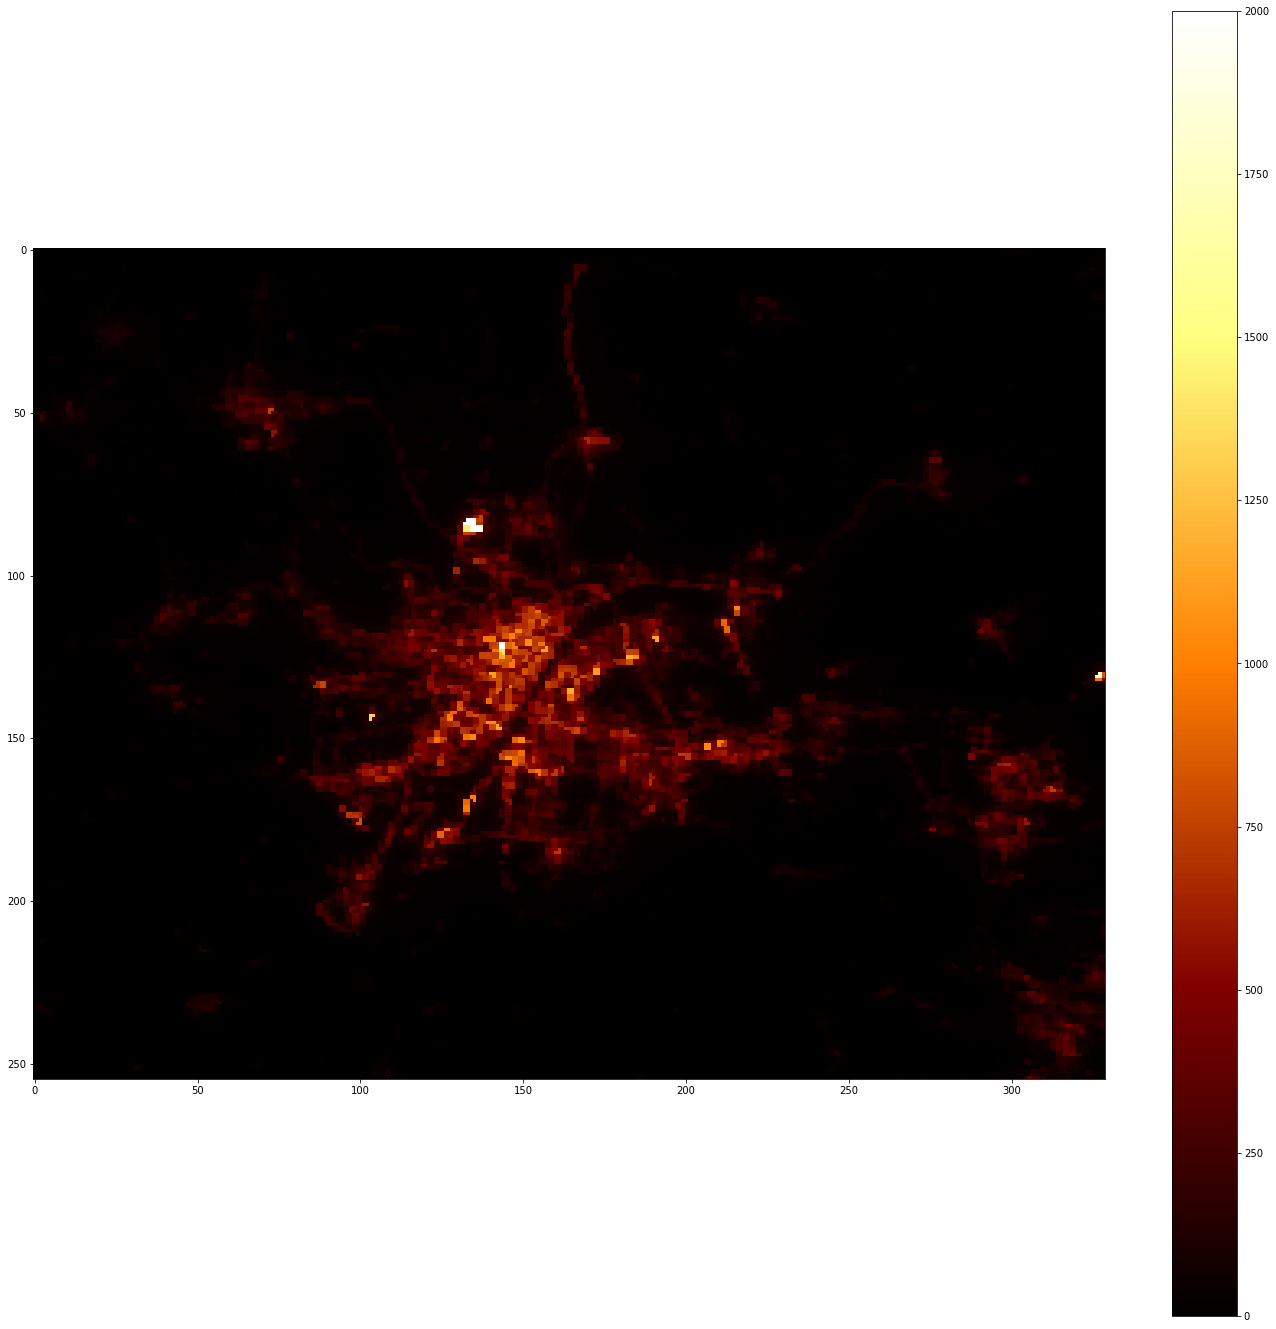

2020-01-29


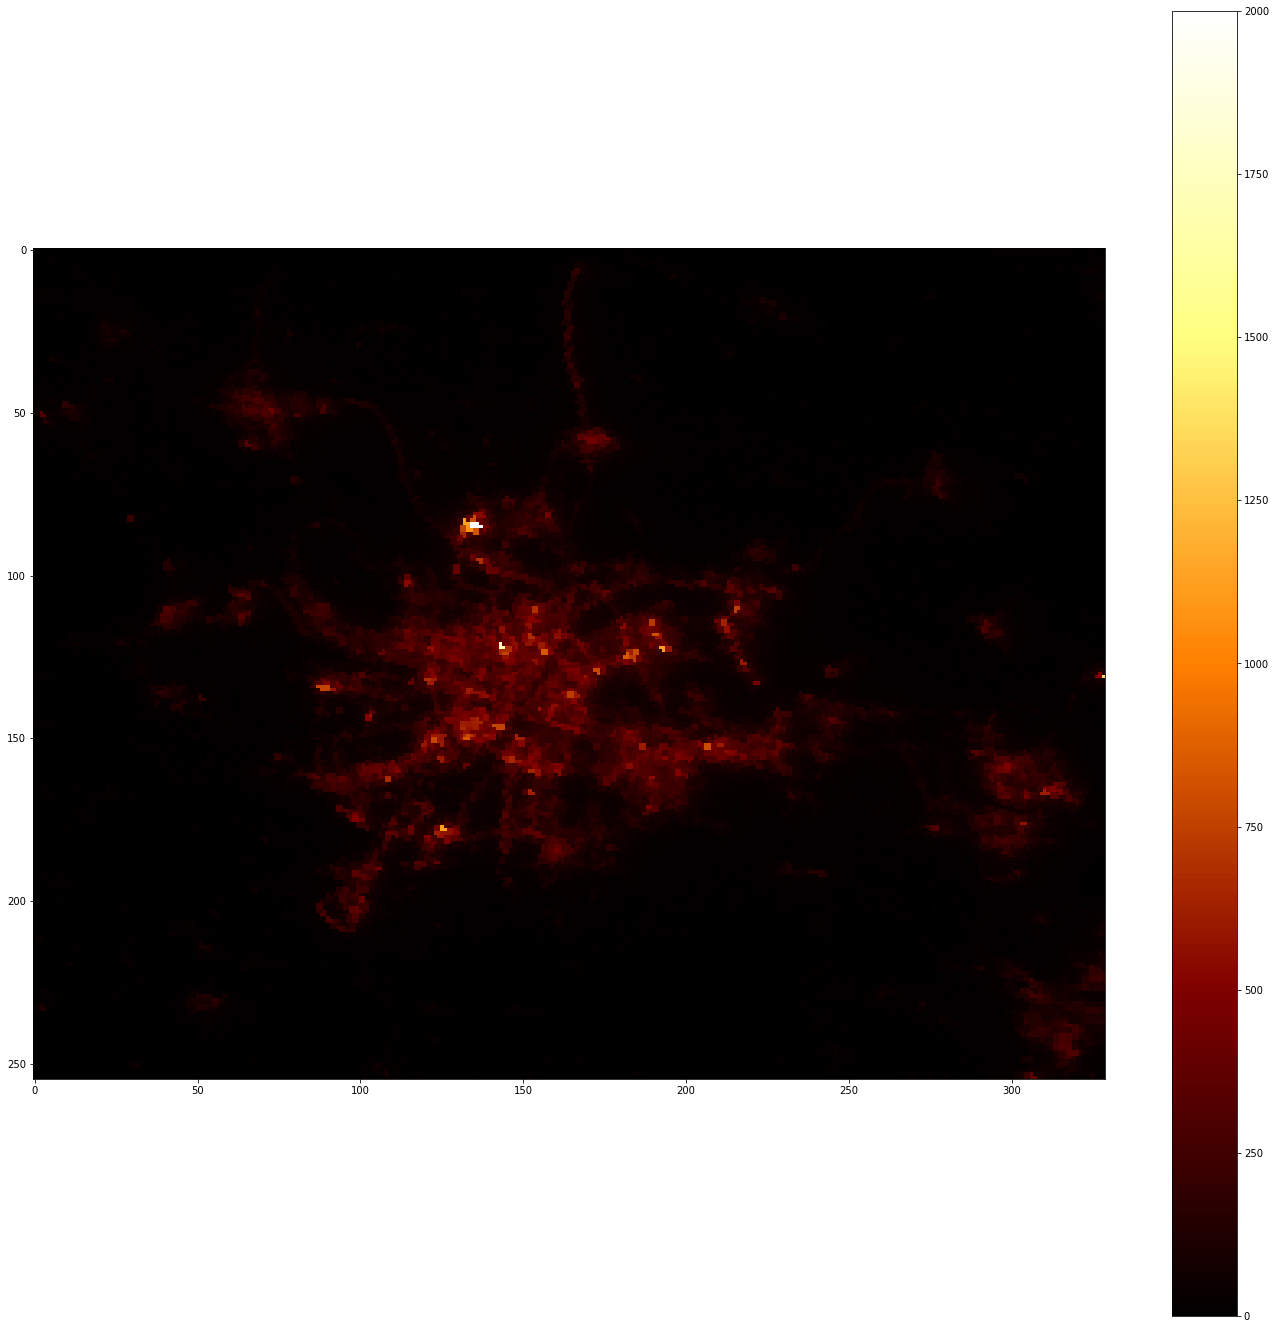

2020-01-30


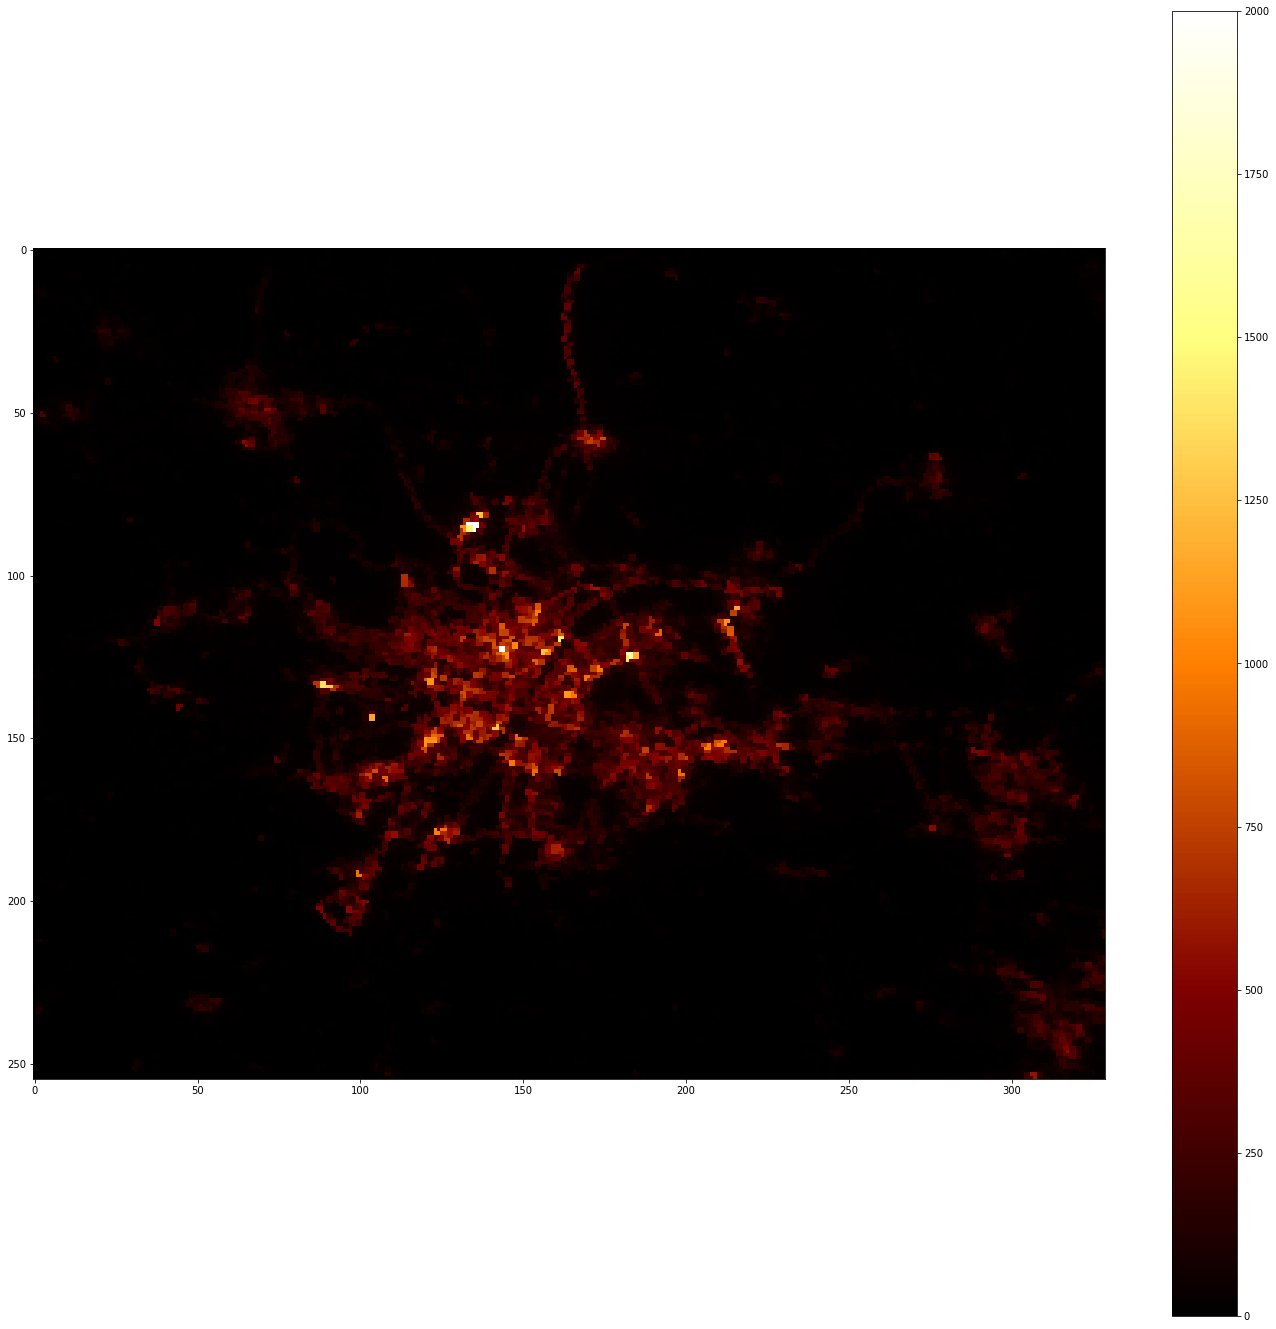

2020-01-31


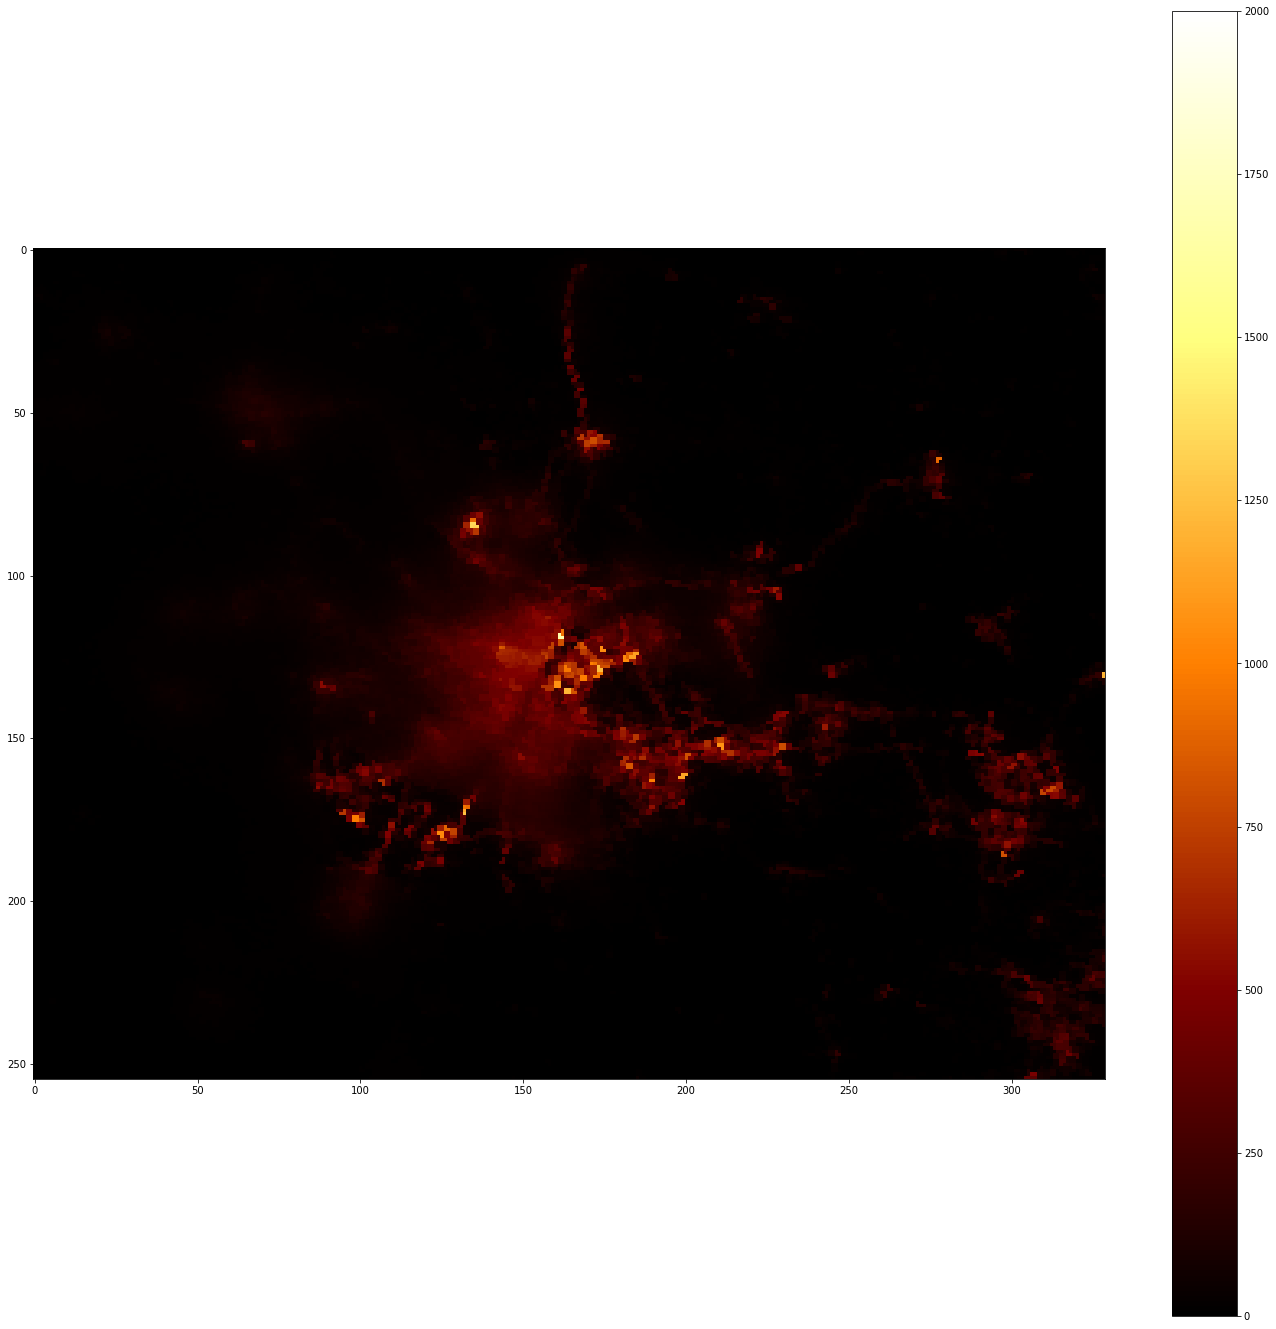

2020-02-01


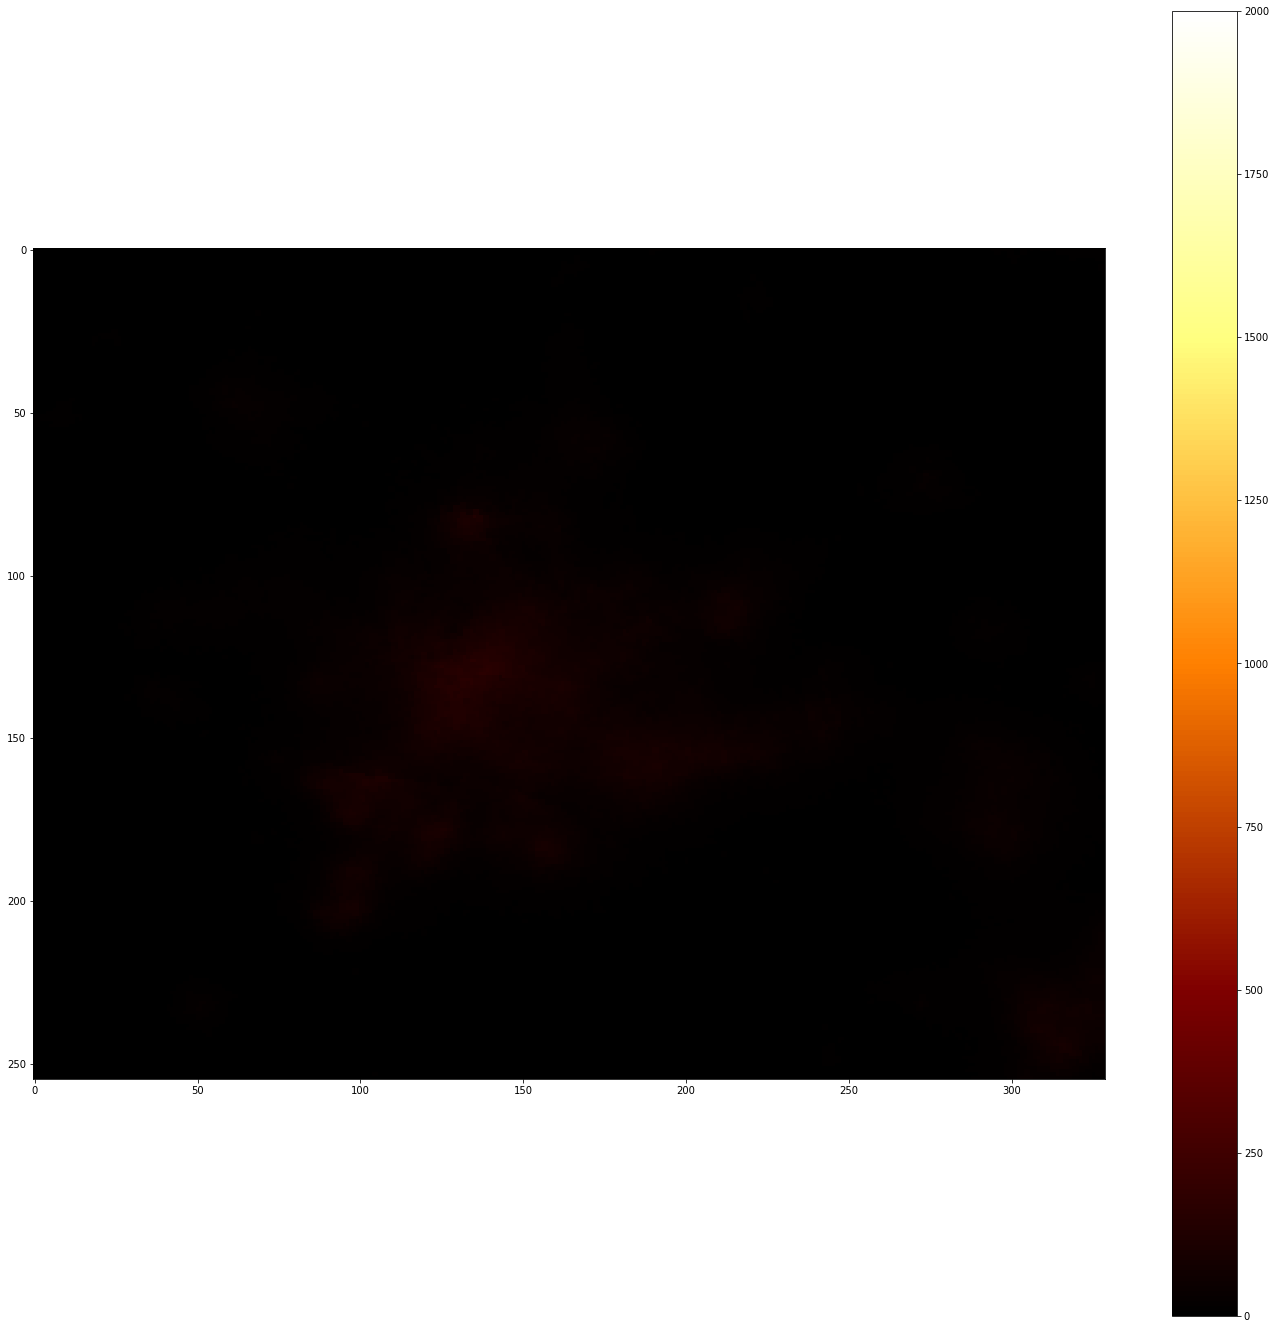

2020-02-02


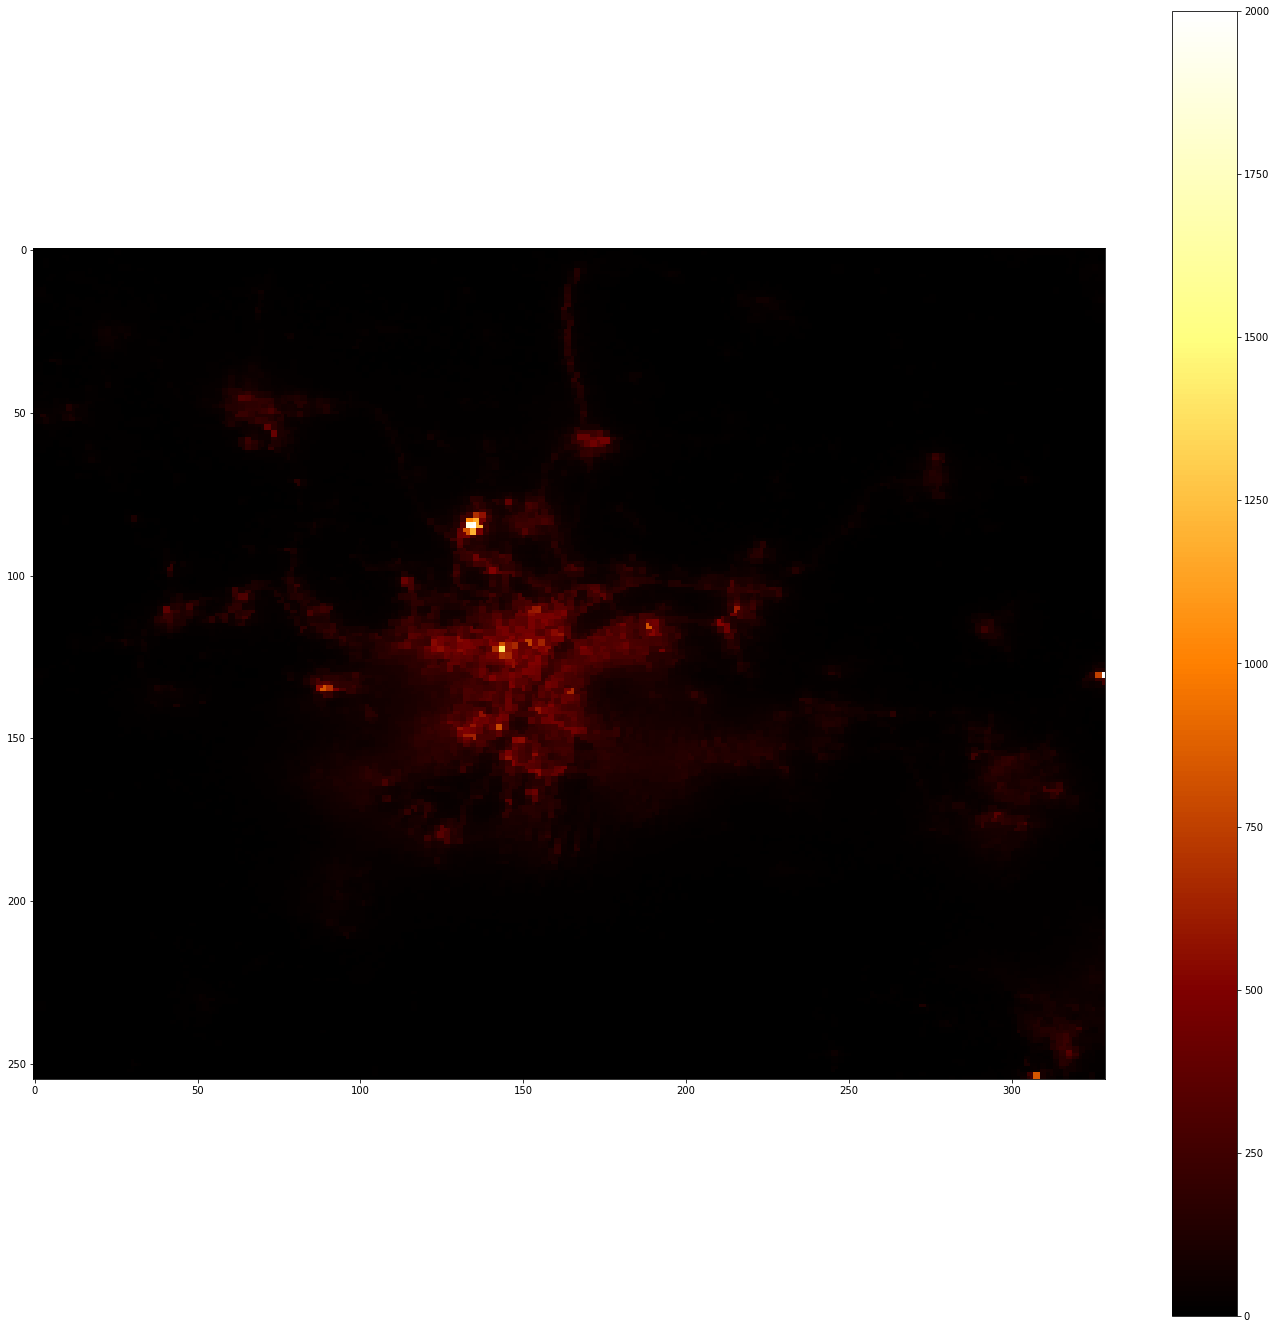

2020-02-03


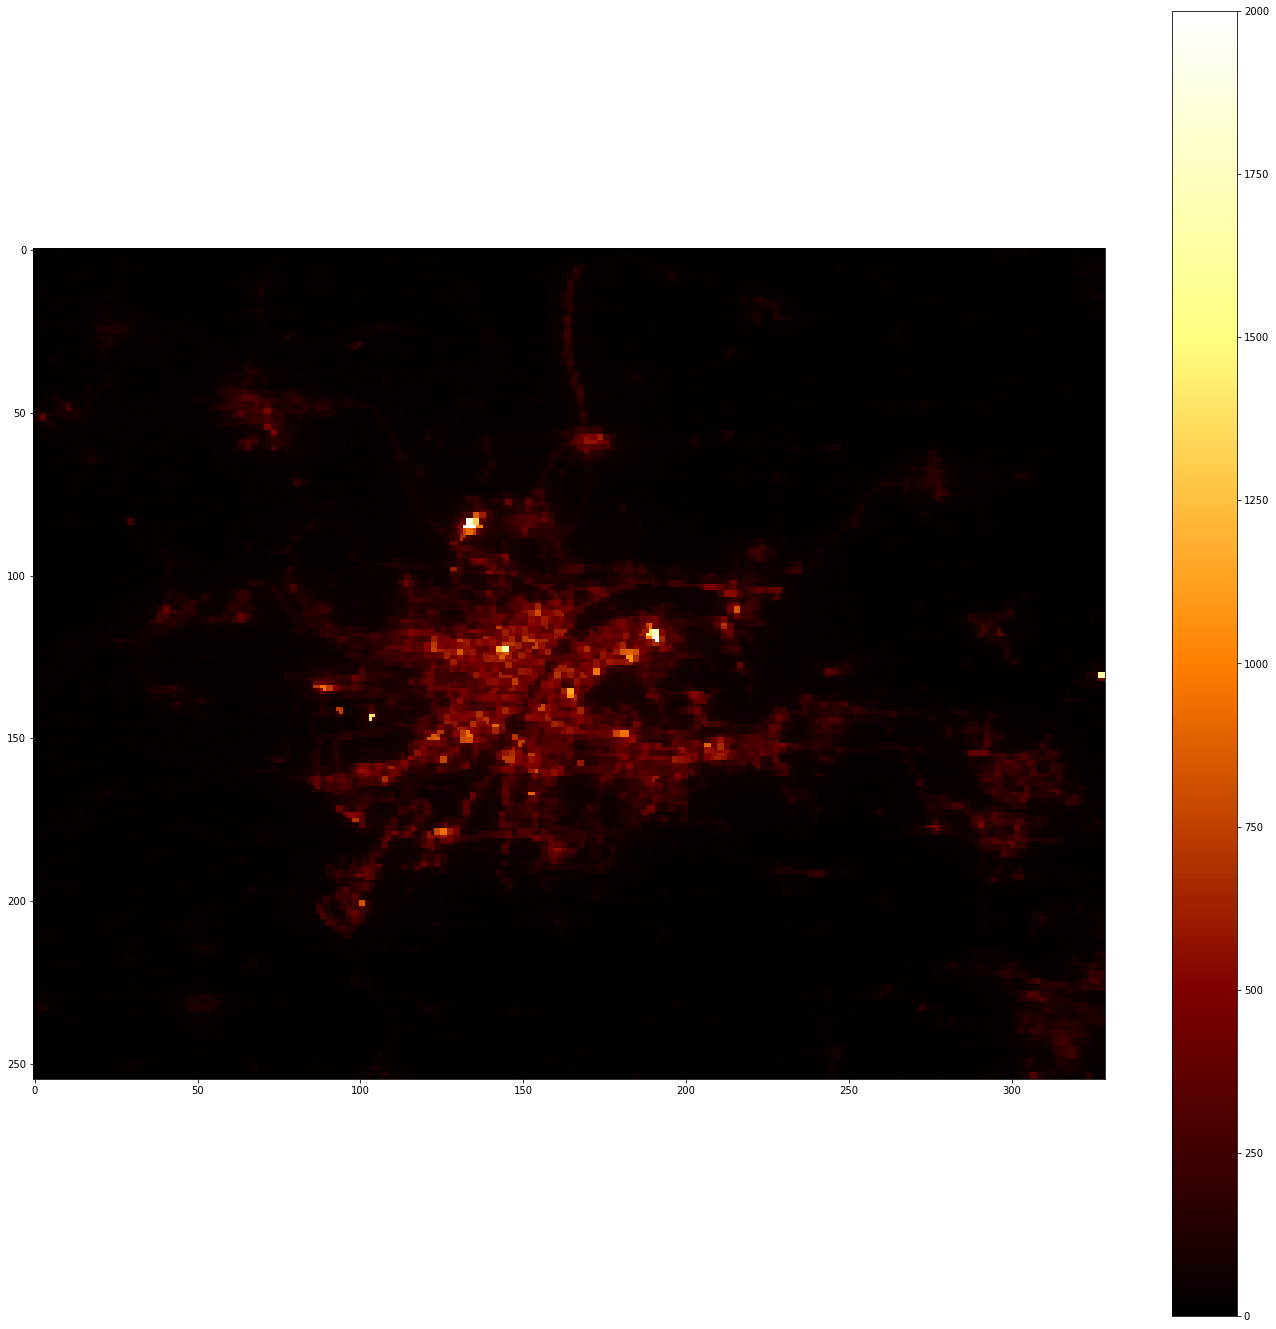

2020-02-04


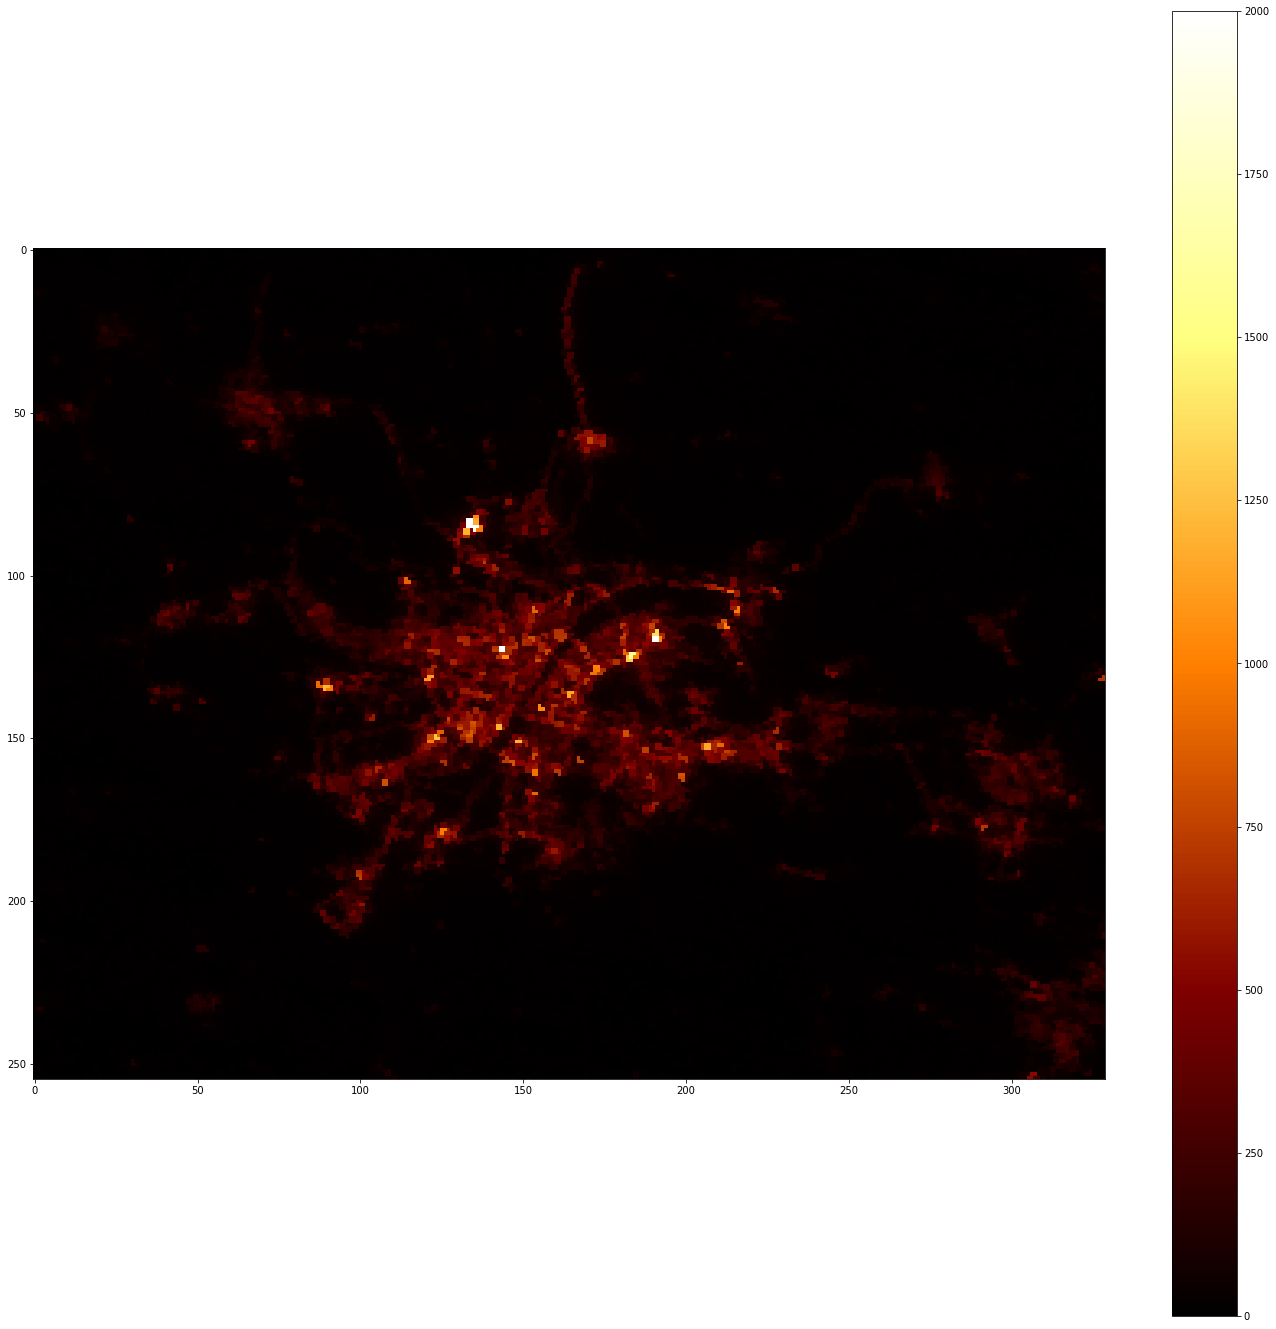

2020-02-05


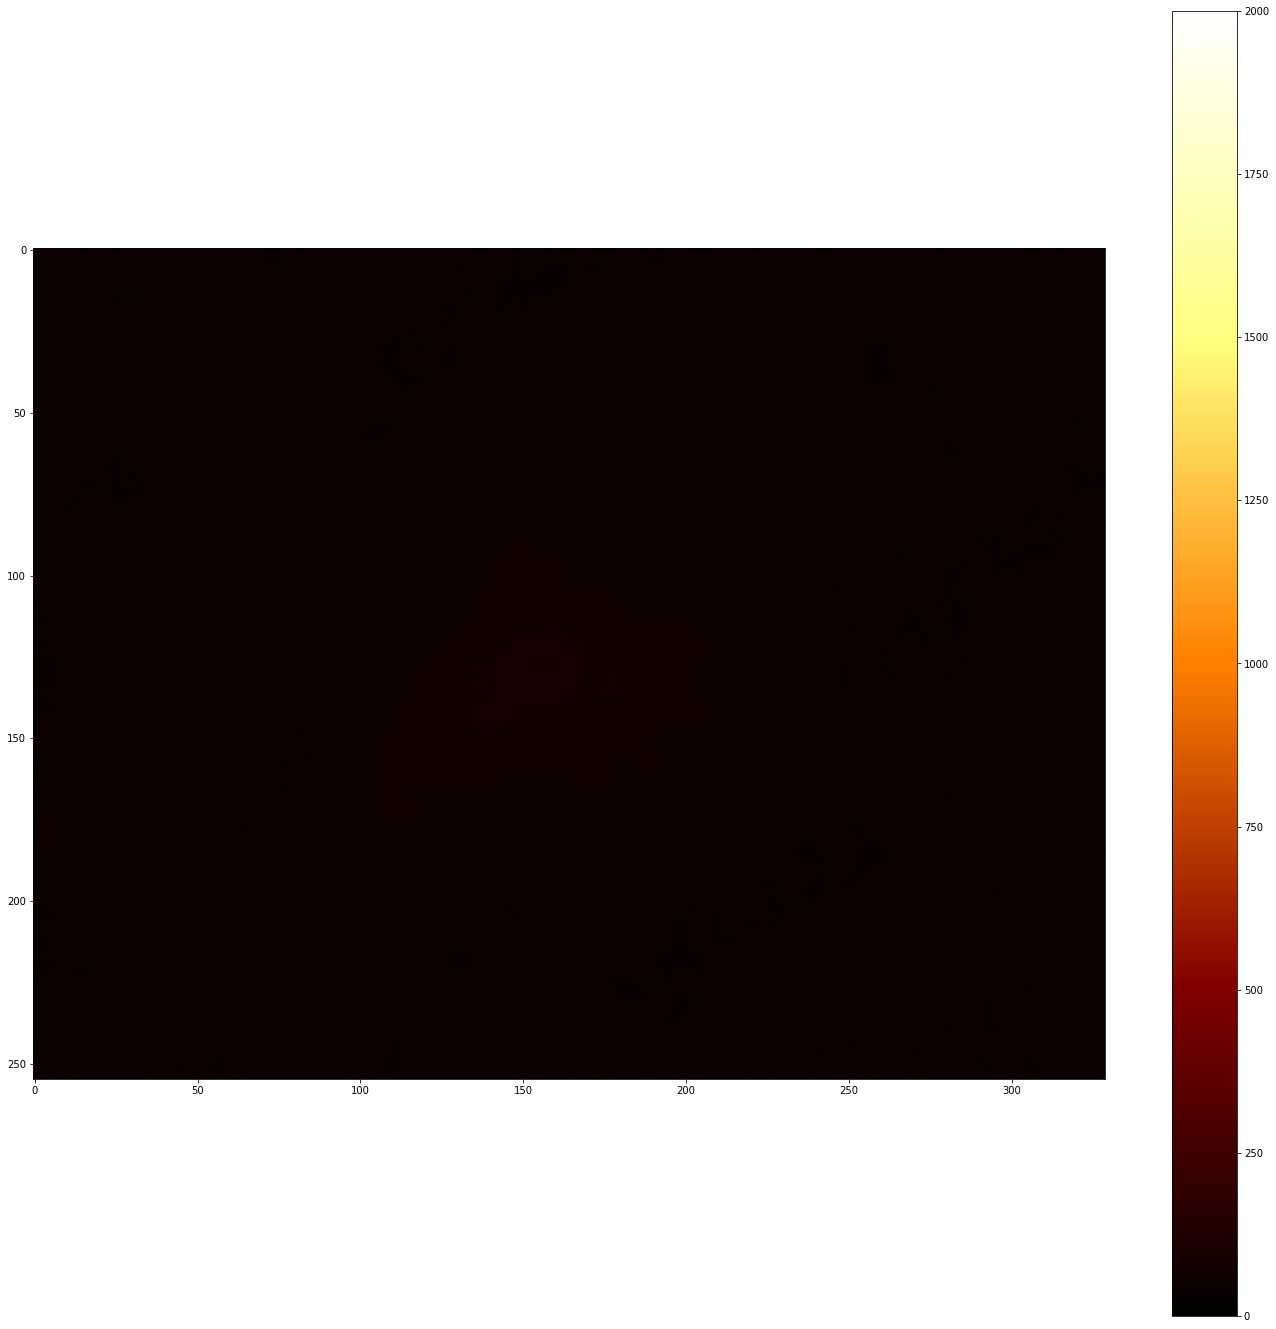

In [22]:
for i in dlist:
    wus = gdal.Open("/Users/brian/Desktop/Grid_DNB_Data_Fields_DNB_At_Sensor_Radiance_500m--"+i+".tiff")
    print(wus.GetMetadata()['HDFEOS_GRIDS_VNP_Grid_DNB_RangeBeginningDate'])
    fm = clip_raster(wus,"wuhan.shp")
    f, ax = plt.subplots(1, figsize=(24,24))
    plt.set_cmap('afmhot')
    plt.imshow(fm[0])
    plt.colorbar()
    plt.clim(0,2000)
    plt.show()

2020-01-18


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:35: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


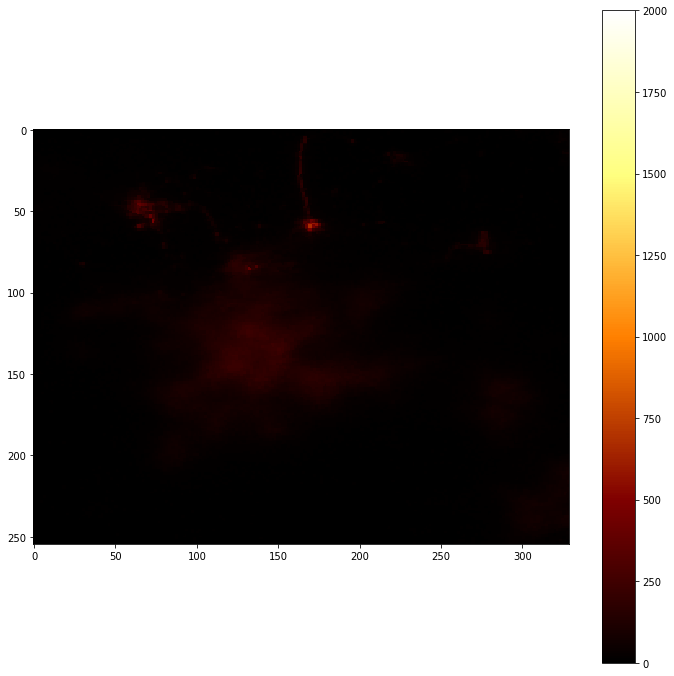

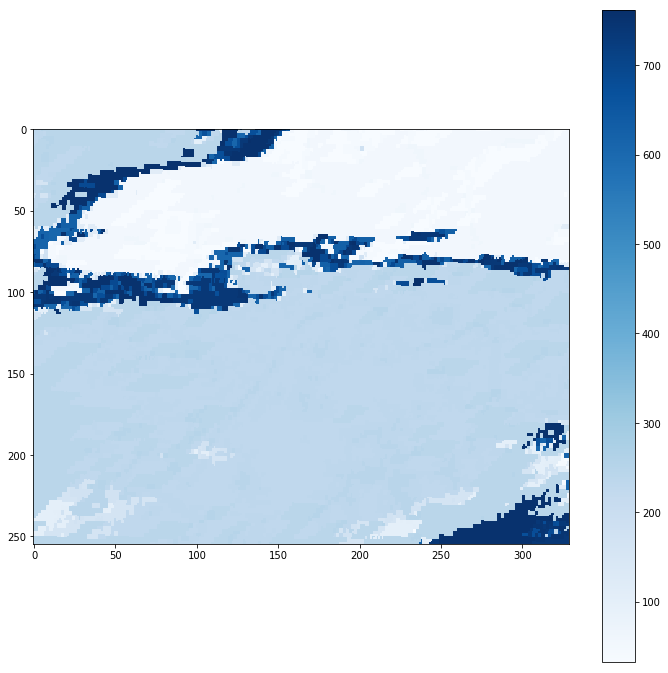

2020-01-19


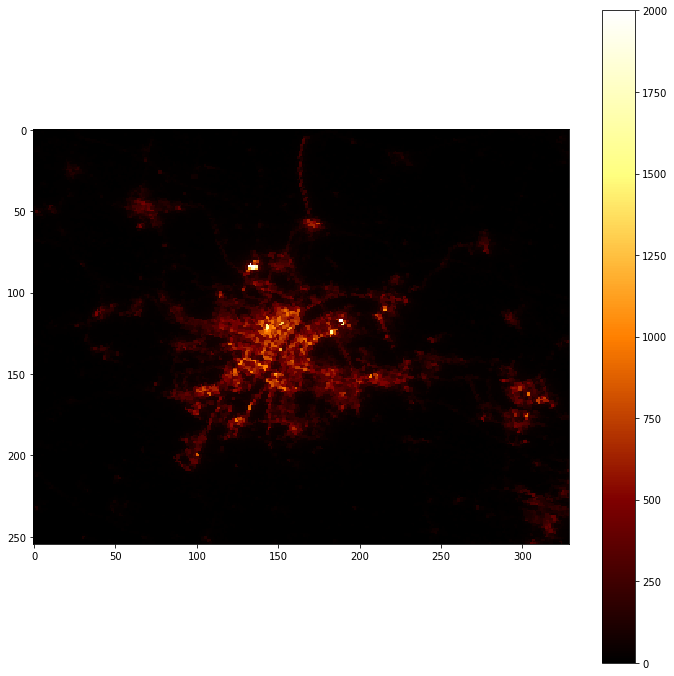

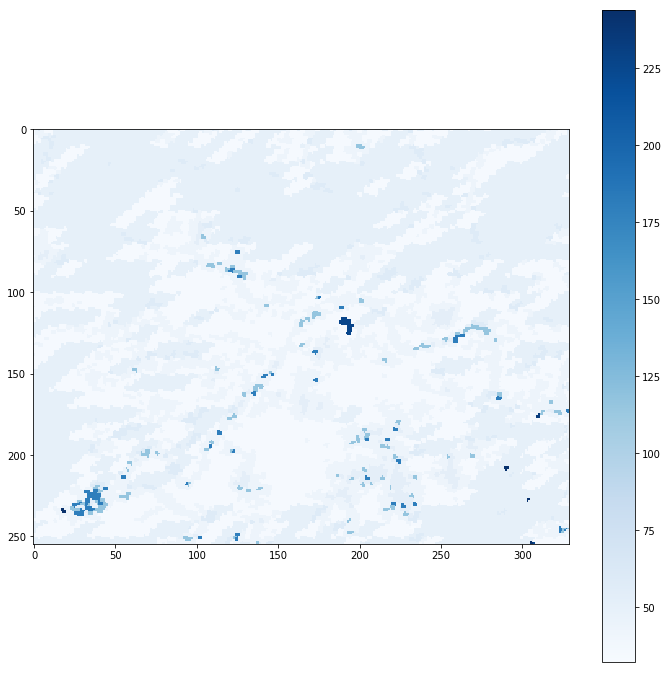

2020-01-20


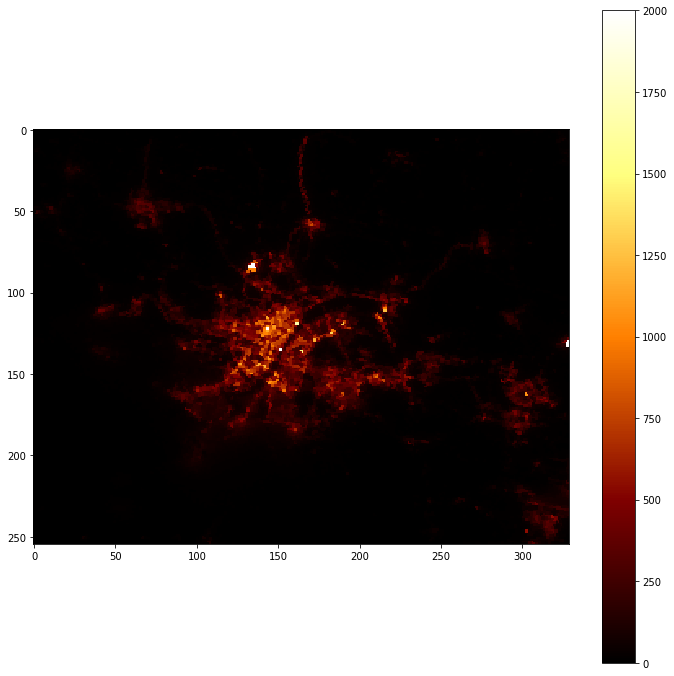

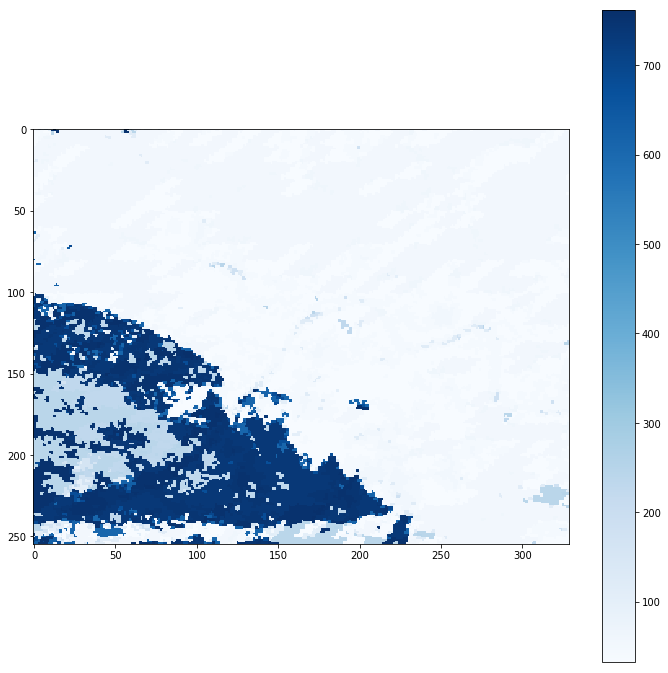

2020-01-21


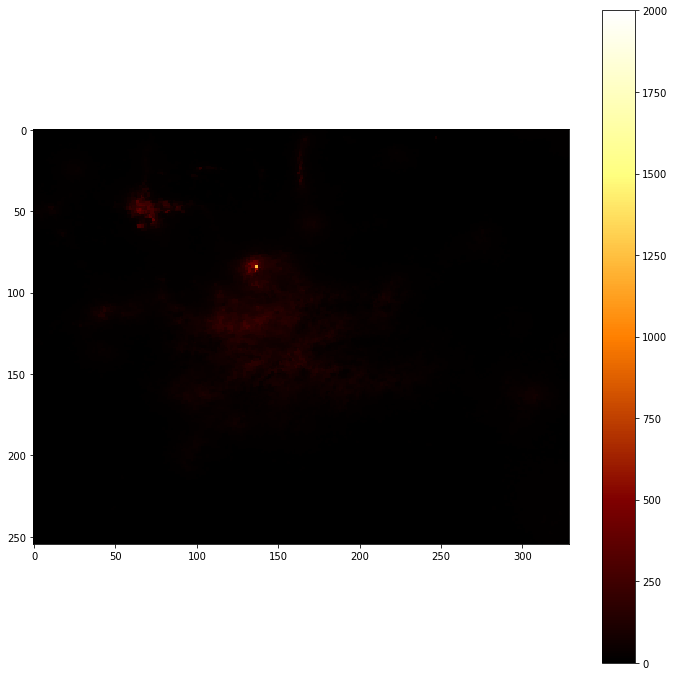

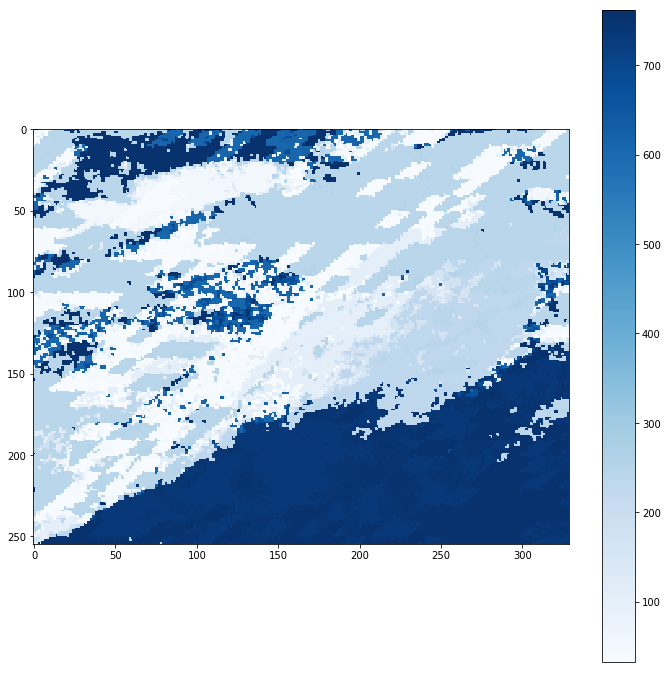

2020-01-22


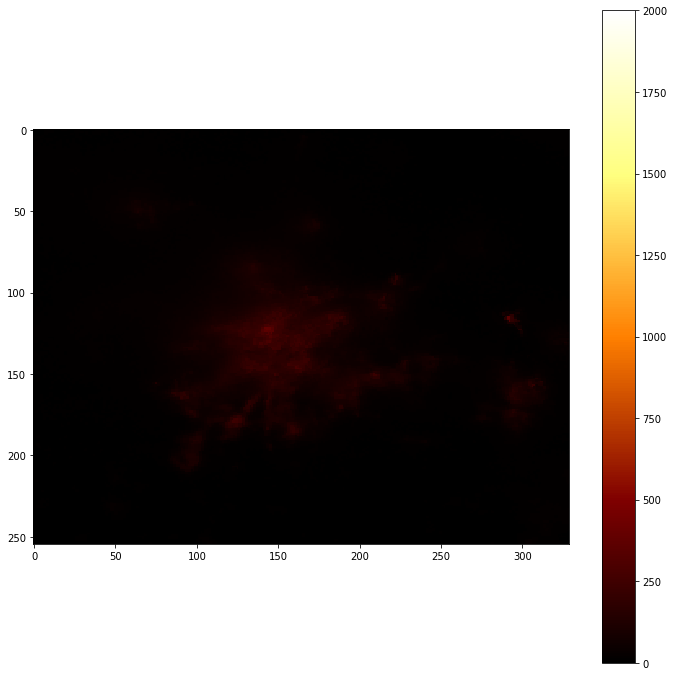

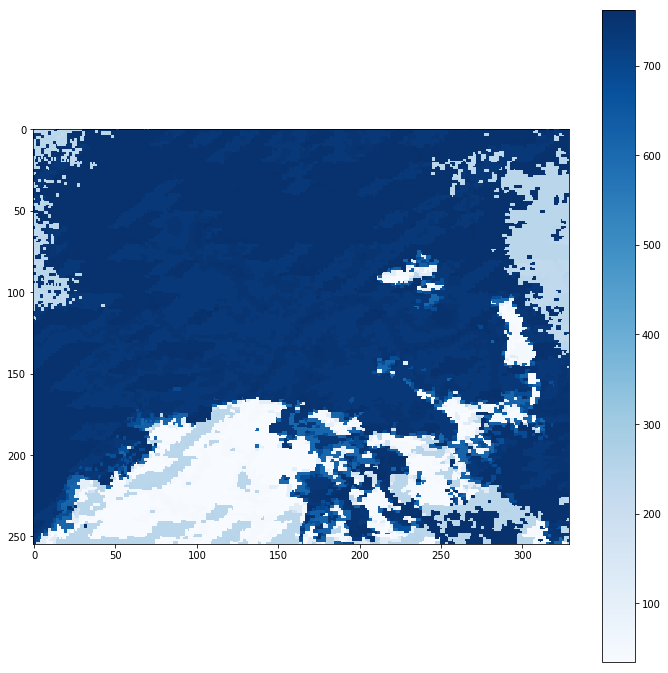

2020-01-24


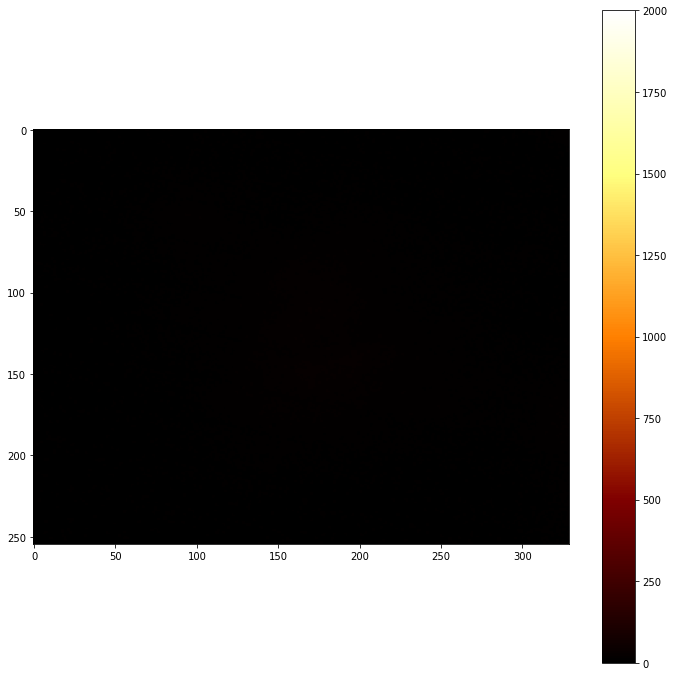

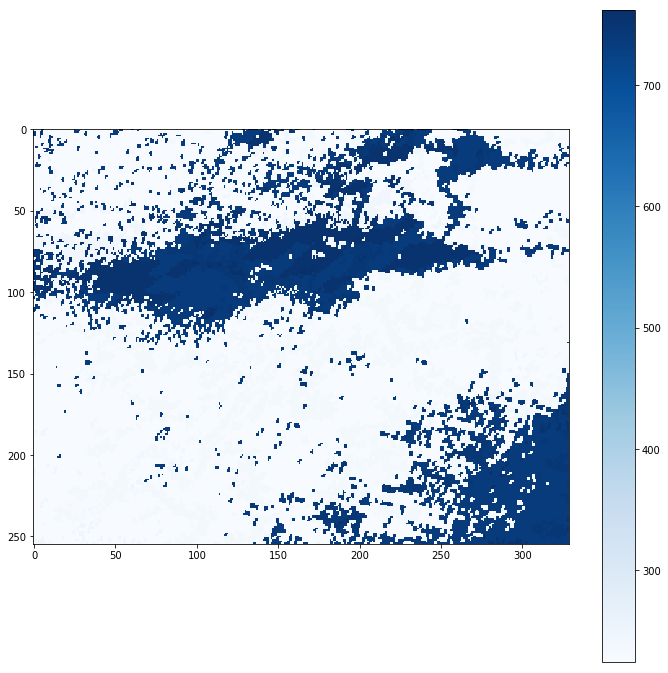

2020-01-25


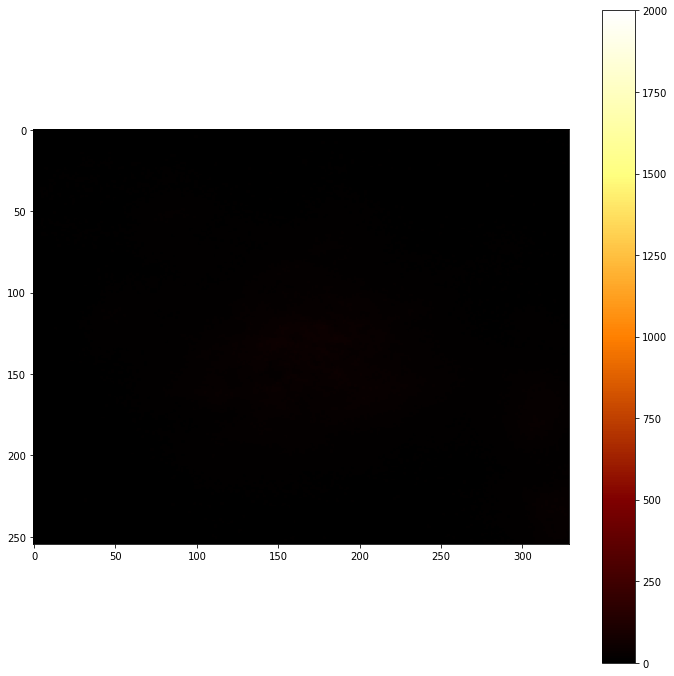

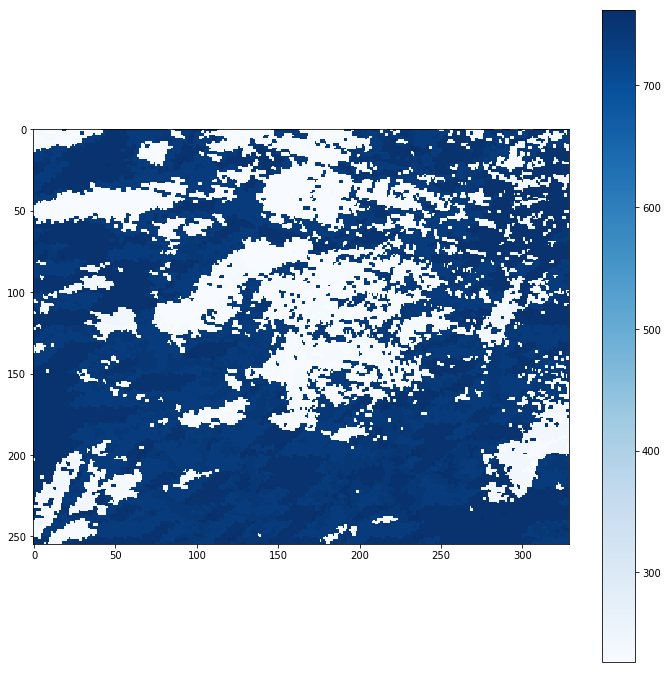

2020-01-27


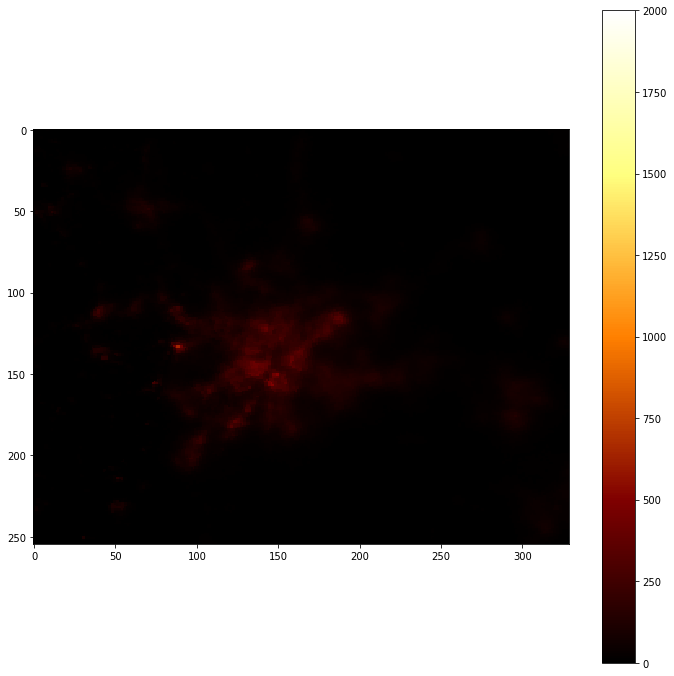

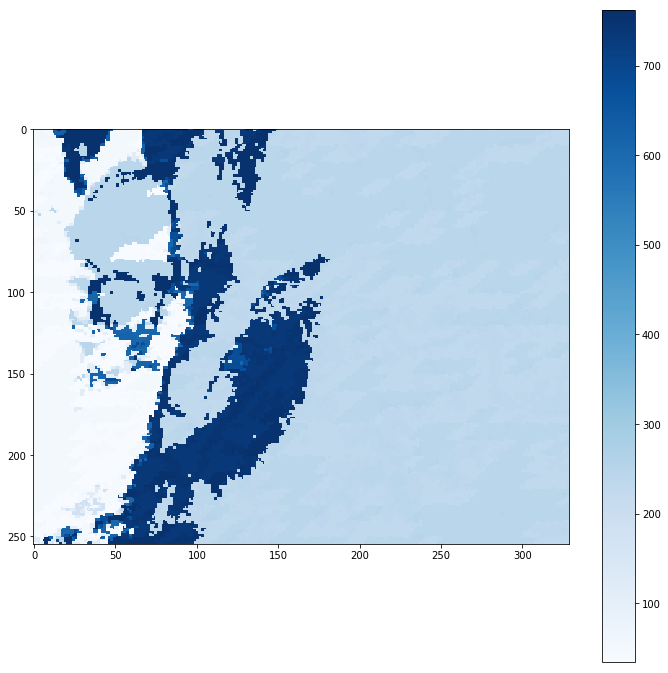

2020-01-28


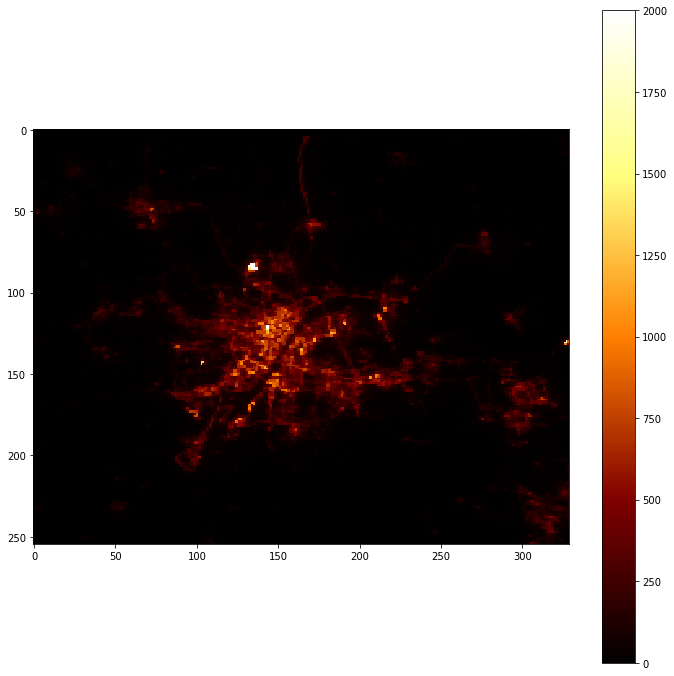

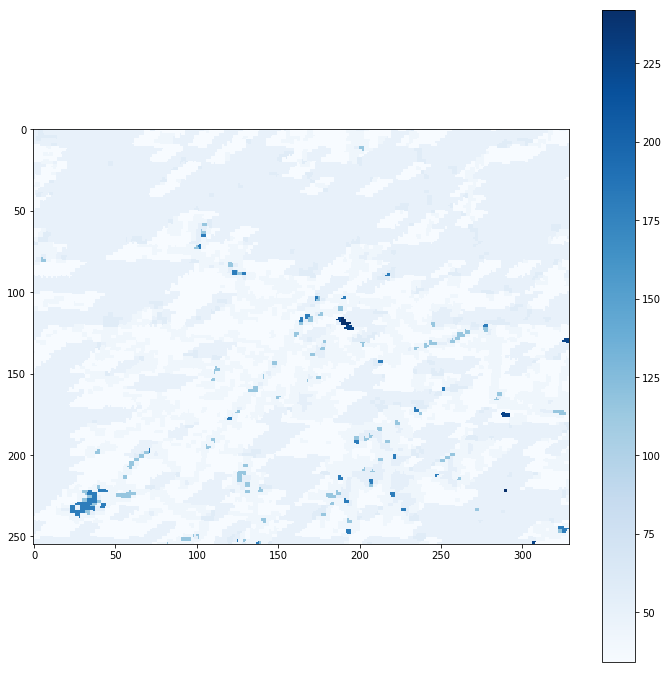

2020-01-29


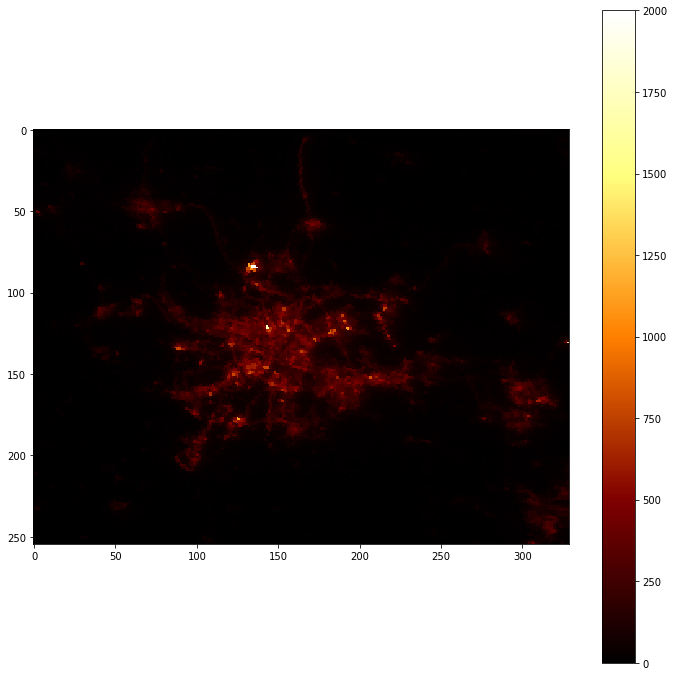

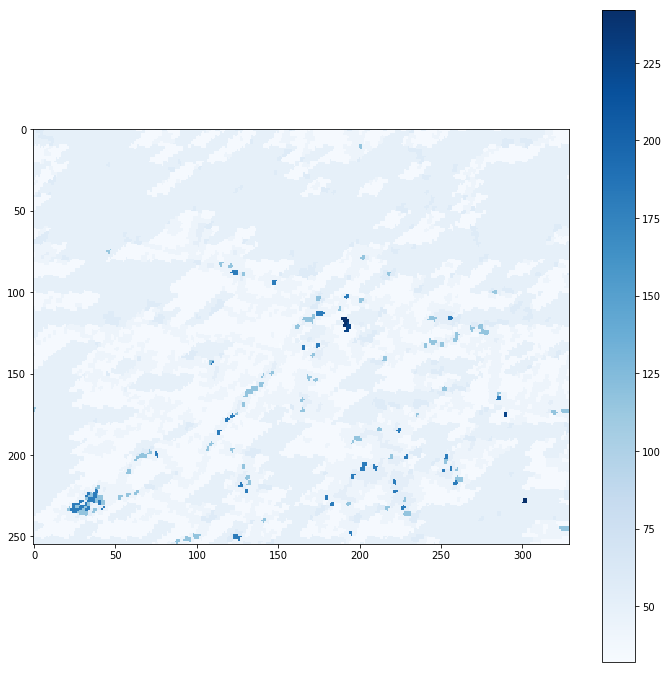

2020-01-30


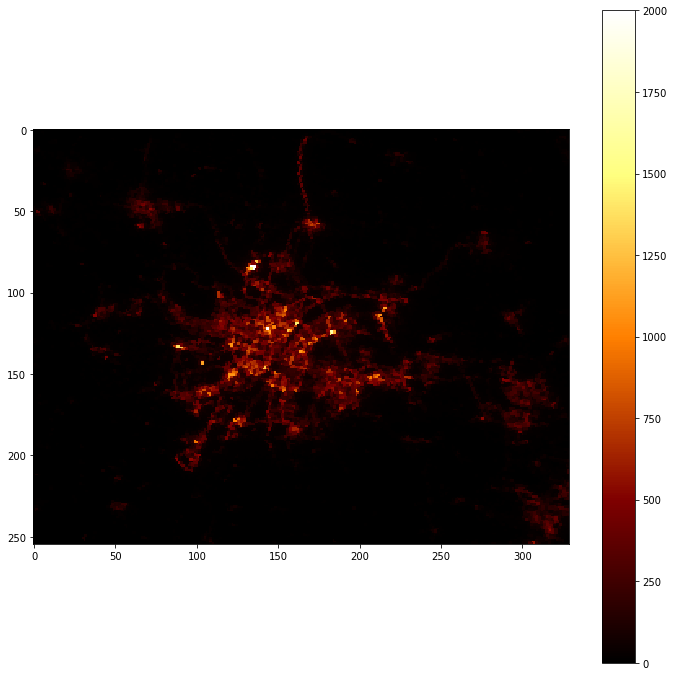

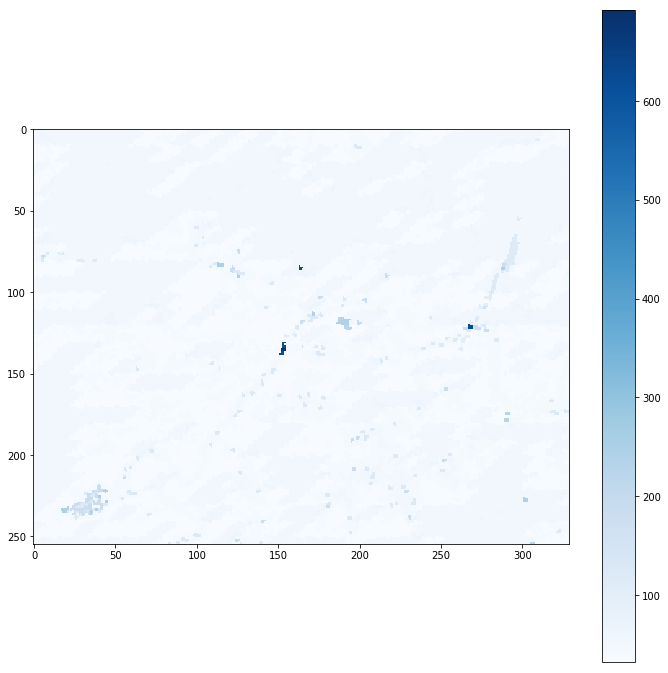

2020-01-31


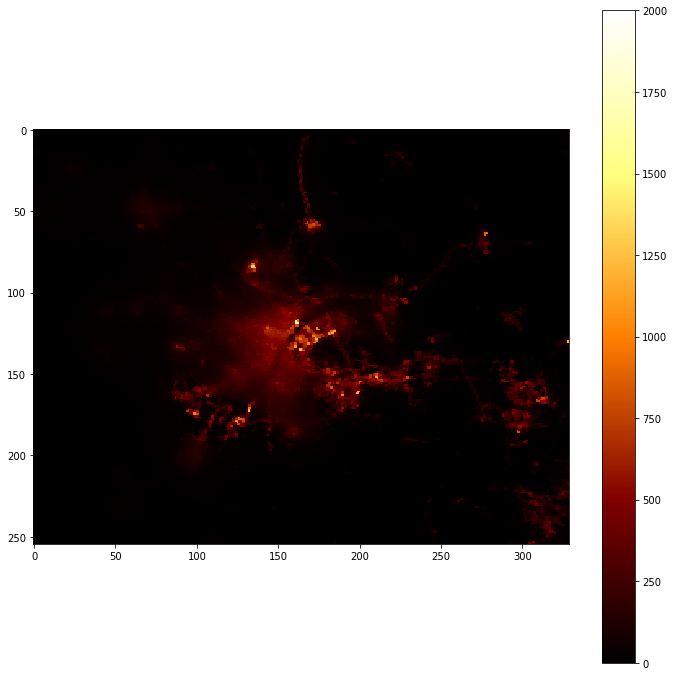

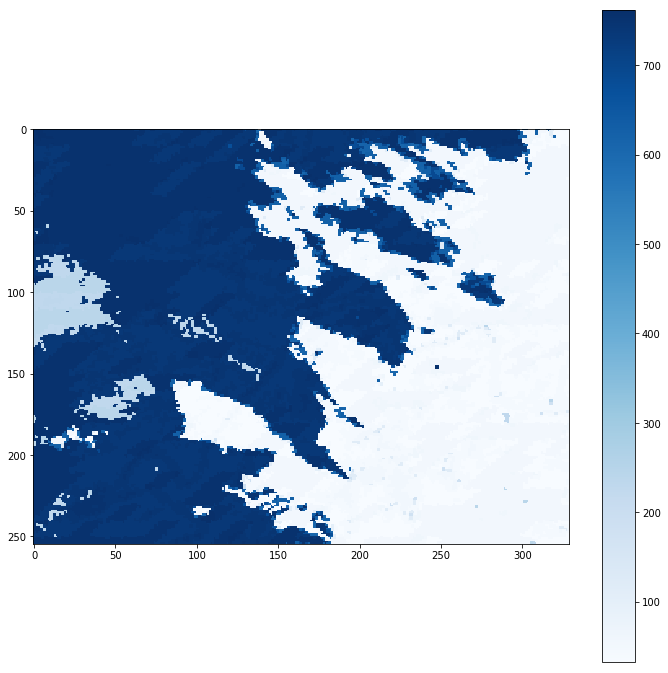

2020-02-01


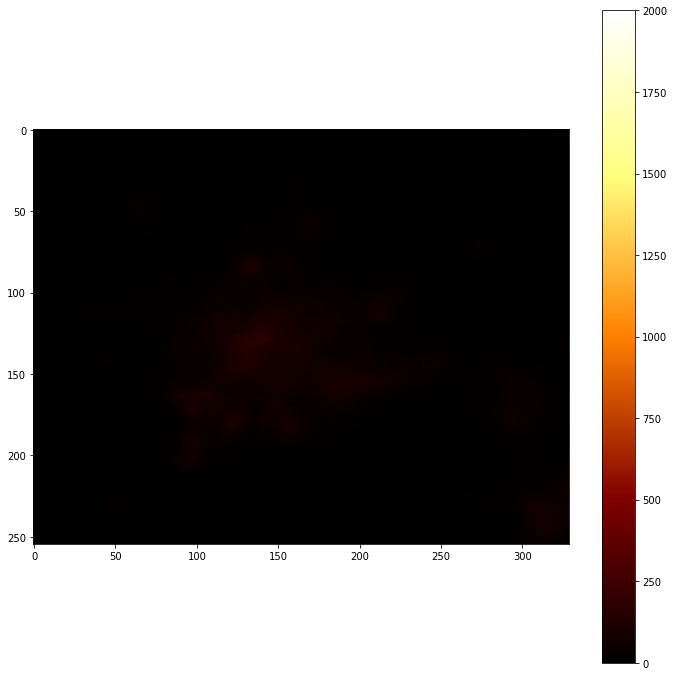

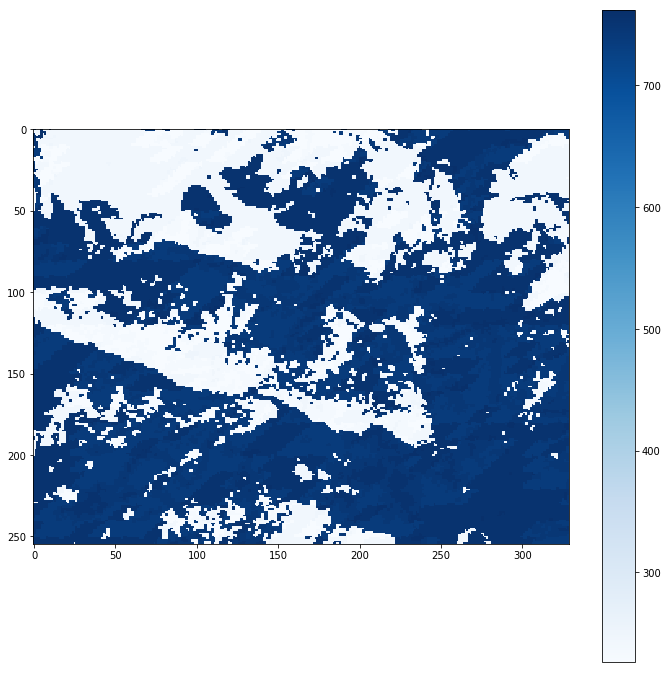

2020-02-02


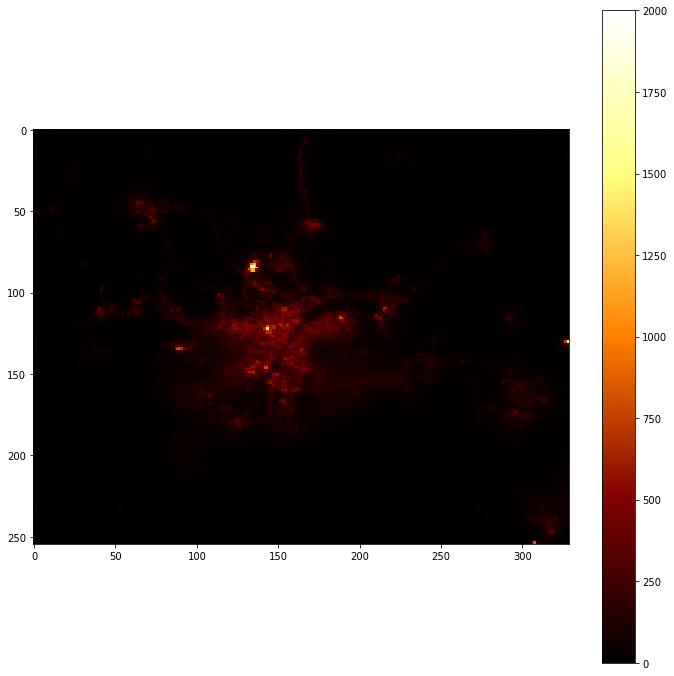

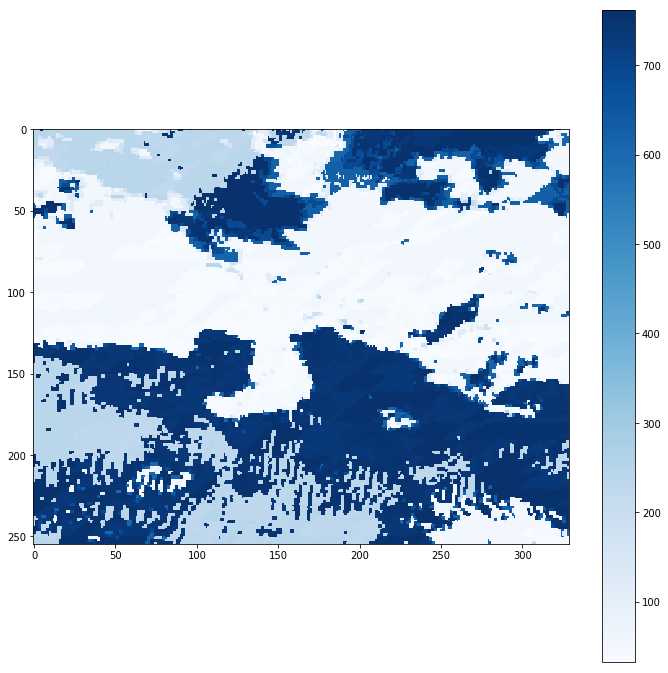

2020-02-03


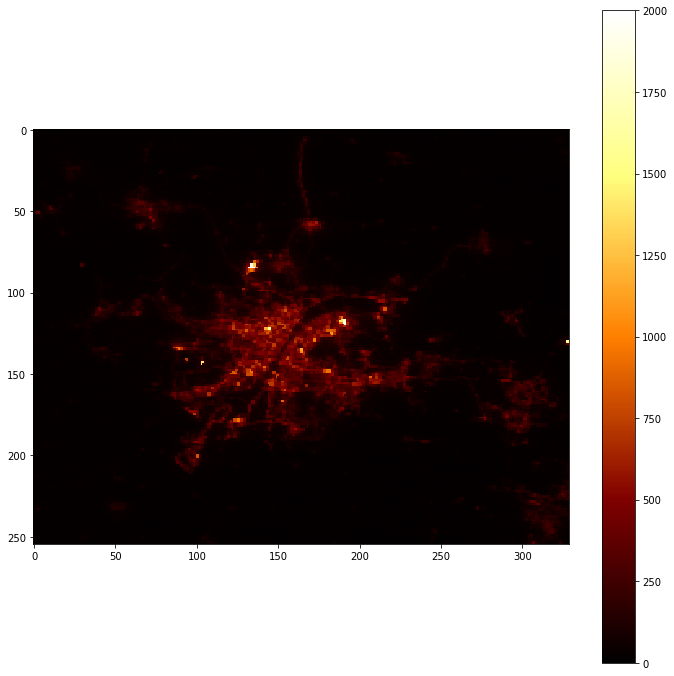

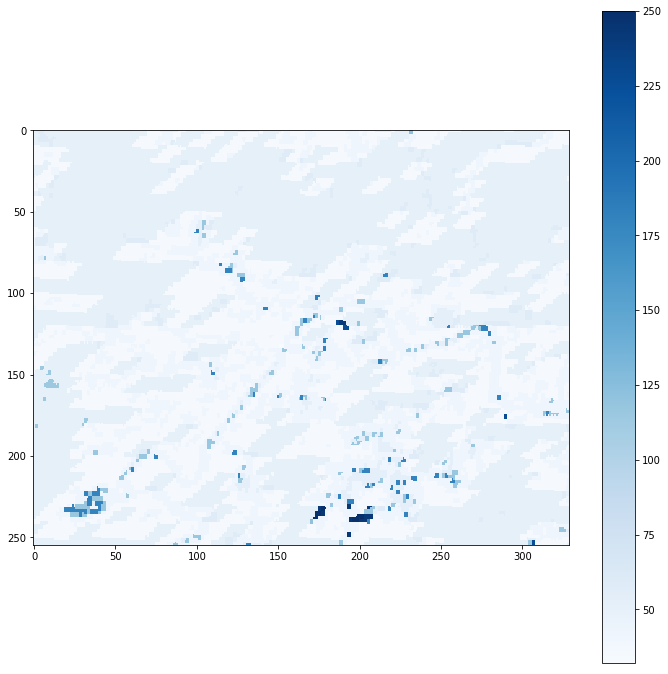

2020-02-04


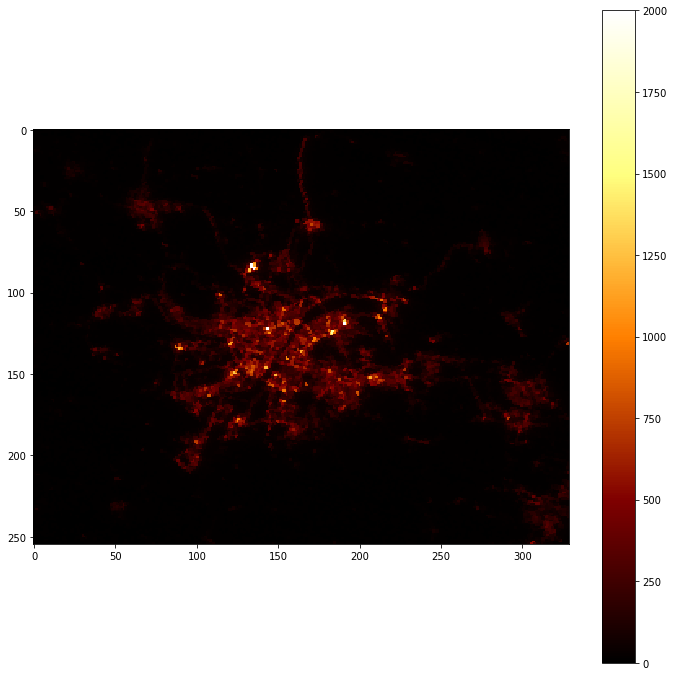

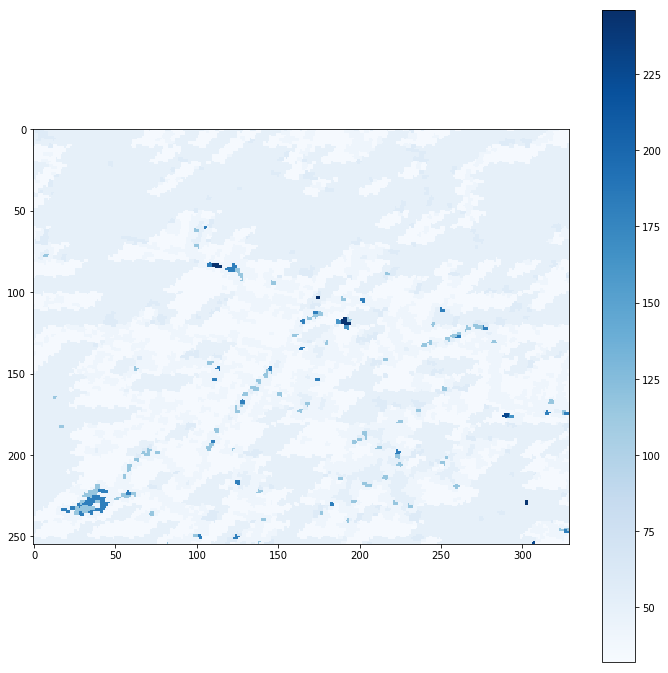

2020-02-05


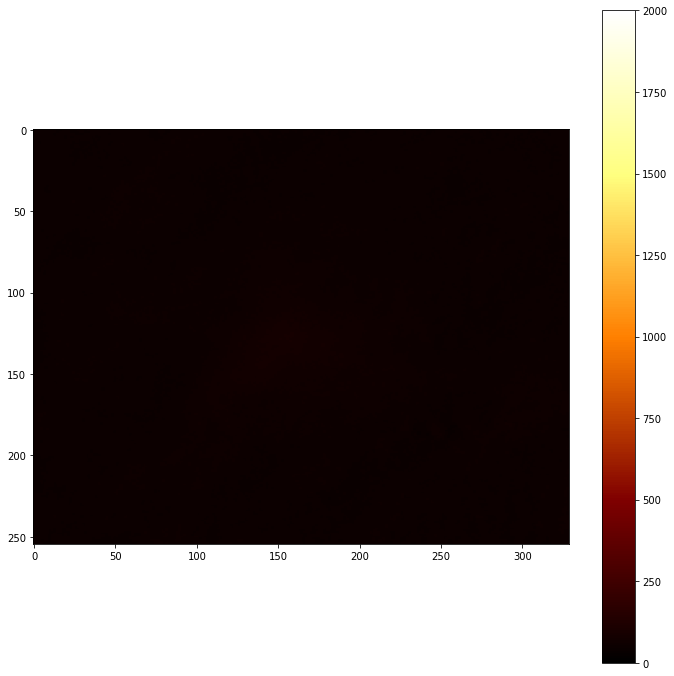

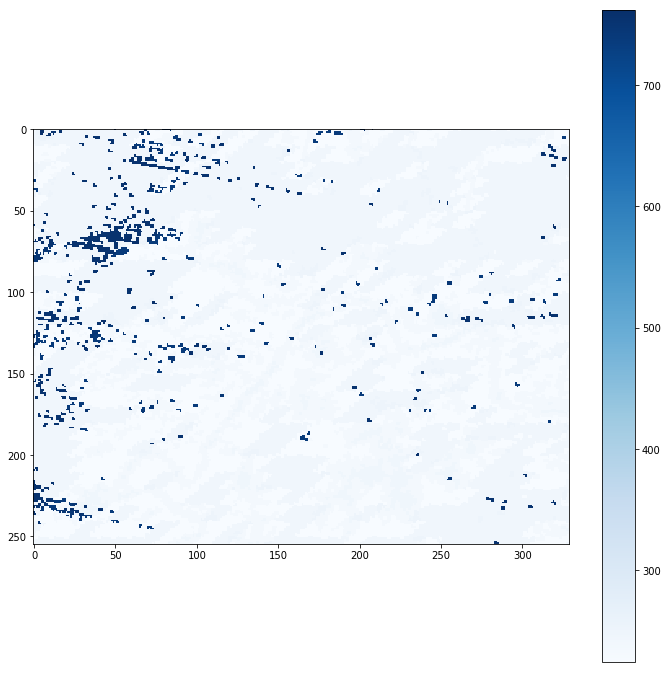

In [23]:
for i in dlist:
    wus = gdal.Open("/Users/brian/Desktop/Grid_DNB_Data_Fields_DNB_At_Sensor_Radiance_500m--"+i+".tiff")
    print(wus.GetMetadata()['HDFEOS_GRIDS_VNP_Grid_DNB_RangeBeginningDate'])
    fm = clip_raster(wus,"wuhan.shp")
    f, ax = plt.subplots(1, figsize=(12,12))
    plt.set_cmap('afmhot')
    plt.imshow(fm[0])
    plt.colorbar()
    plt.clim(0,2000)
    plt.show()
    wus = gdal.Open("/Users/brian/Desktop/Grid_DNB_Data_Fields_QF_Cloud_Mask--"+i+".tiff")
    fm = clip_raster(wus,"wuhan.shp")
    f, ax = plt.subplots(1, figsize=(12,12))
    plt.set_cmap('Blues')
    plt.imshow(fm[0])
    plt.colorbar()
    plt.show()